# NHL Salary Predictions
## By Kyle Dufrane

In [1]:
# Import needed libraries

from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
import pickle

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

######################################################################

import requests
import json
from bs4 import BeautifulSoup
import lxml

######################################################################

import statsmodels.api as sm
from statsmodels.formula.api import ols

from lazypredict.Supervised import LazyRegressor

from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuitCV, LassoCV, LarsCV, SGDRegressor, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor

######################################################################

import plaidml.keras
import os
plaidml.keras.install_backend()
os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'

import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

######################################################################

# All functions are stored in the src folder attached to this repo
import sys
sys.path.insert(0, 'src/')
from modeling import *
from data_cleaning import *

######################################################################

import warnings
warnings.filterwarnings('ignore')

# Business Understanding

### Our stakeholder is the NHLPA (National Hockey League Players Association). Over the long history of the NHL there have been a total of five player strikes regarding pay. The purpose for this project is to devolop a machine learning model that will predict players salaries, excluding goalies (this will require another model due to stats), based on prior performance. 

# Data Understanding

### This dataset comes from two sources being: 

* NHL API - player stats by season
* [Spotrac.com Webscraping](www.sportrac.com) - player salaries by season

### Below we will start our data collections. 

### To start, the below cell pulls from the NHL API and extracts all NHL team information and store the requests objects in a dictionary. We then remove all values that return a 404 error and, finally, store the object in a pickle file. 

#### Note: all pickled objects can be found in the json_files folder

In [2]:
# nhl_teams = {}

# for team in range(1,102):
    
#     url = f"https://statsapi.web.nhl.com/api/v1/teams/{team}"

#     headers = {
#         'x-rapidapi-key': "c10092ada9mshd8d43cac6b3023cp1b369ajsn4c45f8f530d0",
#         'x-rapidapi-host': "api-hockey.p.rapidapi.com"
#     }

#     nhl_teams[team] = requests.request("GET", url, headers=headers)


In [3]:
# errors_404 = [59, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 83, 84, 85, 86, 99]

# for i in errors_404:
#     nhl_teams.pop(i)

In [4]:
# pickle_out = open("json_files/nhl_teams.pickle","wb")
# pickle.dump(nhl_teams, pickle_out)
# pickle_out.close()

pickle_in = open("json_files/nhl_teams.pickle","rb")
nhl_teams = pickle.load(pickle_in)

all_teams_df = get_teams(nhl_teams)
all_teams_df.head()

,id,name,link,venue_name,venue_link,venue_city,venue_timeZone,abbreviation,teamName,locationName,firstYearOfPlay,division_id,division_name,division_link,conference_id,conference_name,conference_link,franchise_franchiseId,franchise_teamName,franchise_link,shortName,officialSiteUrl,franchiseId,active,venue_id,division_nameShort,division_abbreviation
1,1,New Jersey Devils,/api/v1/teams/1,Prudential Center,/api/v1/venues/null,Newark,America/New_York,NJD,Devils,New Jersey,1982,25,MassMutual East,/api/v1/divisions/25,6,Eastern,/api/v1/conferences/6,23,Devils,/api/v1/franchises/23,New Jersey,http://www.newjerseydevils.com/,23,True,NaN,NaN,NaN
2,2,New York Islanders,/api/v1/teams/2,Nassau Veterans Memorial Coliseum,/api/v1/venues/null,Uniondale,America/New_York,NYI,Islanders,New York,1972,25,MassMutual East,/api/v1/divisions/25,6,Eastern,/api/v1/conferences/6,22,Islanders,/api/v1/franchises/22,NY Islanders,http://www.newyorkislanders.com/,22,True,NaN,NaN,NaN
3,3,New York Rangers,/api/v1/teams/3,Madison Square Garden,/api/v1/venues/5054,New York,America/New_York,NYR,Rangers,New York,1926,25,MassMutual East,/api/v1/divisions/25,6,Eastern,/api/v1/conferences/6,10,Rangers,/api/v1/franchises/10,NY Rangers,http://www.newyorkrangers.com/,10,True,5054,NaN,NaN
4,4,Philadelphia Flyers,/api/v1/teams/4,Wells Fargo Center,/api/v1/venues/5096,Philadelphia,America/New_York,PHI,Flyers,Philadelphia,1967,25,MassMutual East,/api/v1/divisions/25,6,Eastern,/api/v1/conferences/6,16,Flyers,/api/v1/franchises/16,Philadelphia,http://www.philadelphiaflyers.com/,16,True,5096,NaN,NaN
5,5,Pittsburgh Penguins,/api/v1/teams/5,PPG Paints Arena,/api/v1/venues/5034,Pittsburgh,America/New_York,PIT,Penguins,Pittsburgh,1967,25,MassMutual East,/api/v1/divisions/25,6,Eastern,/api/v1/conferences/6,17,Penguins,/api/v1/franchises/17,Pittsburgh,http://pittsburghpenguins.com/,17,True,5034,NaN,NaN


### Above, we run our JSON files through a function which converts our data into a pandas dataframe. 

#### Note: This process is identifcal for all NHL API pulls.

### Below we attempt to pull stadium and franchise information from the links associated in the above dataframe but are unable to get any return information.

In [5]:
# nhl_team_stadiums = {}

# for link in all_teams_df['venue_link']:

#     url = f"https://statsapi.web.nhl.com/api/v1/teams/{link}/roster"

#     headers = {
#         'x-rapidapi-key': "c10092ada9mshd8d43cac6b3023cp1b369ajsn4c45f8f530d0",
#         'x-rapidapi-host': "api-hockey.p.rapidapi.com"
#     }

#     nhl_team_stadiums[link] = requests.request("GET", url, headers=headers)

print('Response [404]')

Response [404]


In [6]:
# nhl_team_franchise = {}

# for link in all_teams_df['franchise_link']:

#     url = f"https://statsapi.web.nhl.com/api/v1/teams/{link}/roster"

#     headers = {
#         'x-rapidapi-key': "c10092ada9mshd8d43cac6b3023cp1b369ajsn4c45f8f530d0",
#         'x-rapidapi-host': "api-hockey.p.rapidapi.com"
#     }

#     nhl_team_franchise[link] = requests.request("GET", url, headers=headers)

print('Response [404]')

Response [404]


### Next we move to extract team roster information from the NHL API. Again, we remove the 404 errors, store our JSON files in a dictionary, pickle the object, run our dictionary through our function, and return a pandas dataframe. 

In [7]:
# nhl_team_roster = {}

# for number in range(1,55):

#     url = f"https://statsapi.web.nhl.com/api/v1/teams/{number}/roster"

#     headers = {
#         'x-rapidapi-key': "c10092ada9mshd8d43cac6b3023cp1b369ajsn4c45f8f530d0",
#         'x-rapidapi-host': "api-hockey.p.rapidapi.com"
#     }

#     nhl_team_roster[number] = requests.request("GET", url, headers=headers)

In [8]:
# roster_error_404 = [11, 27, 31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]
# for error in roster_error_404:
#     nhl_team_roster.pop(error)

In [9]:
# pickle_out = open("json_files/nhl_rosters.pickle","wb")
# pickle.dump(nhl_team_roster, pickle_out)
# pickle_out.close()

In [10]:
pickle_in = open("json_files/nhl_rosters.pickle","rb")
nhl_rosters = pickle.load(pickle_in)

In [11]:
rosters = build_roster(nhl_rosters)
rosters.head()

,id,fullName,link,jerseyNumber,code,name,type,abbreviation,Team_Number
0,8477972,Josh Jacobs,/api/v1/people/8477972,40,D,Defenseman,Defenseman,D,1
1,8478421,A.J. Greer,/api/v1/people/8478421,42,L,Left Wing,Forward,LW,1
2,8474056,P.K. Subban,/api/v1/people/8474056,76,D,Defenseman,Defenseman,D,1
3,8475809,Scott Wedgewood,/api/v1/people/8475809,41,G,Goalie,Goalie,G,1
4,8476807,Matt Tennyson,/api/v1/people/8476807,7,D,Defenseman,Defenseman,D,1


In [12]:
rosters = rosters.astype('object')
# rosters.info()

### Next we will pull player specific stats using the link column from the above dataframe & join the new dataframe with the rosters dataframe using the 'id' column

In [13]:
# player_stats = {}
# for link in rosters['link']:

#     url = f"https://statsapi.web.nhl.com/{link}"

#     headers = {
#         'x-rapidapi-key': "c10092ada9mshd8d43cac6b3023cp1b369ajsn4c45f8f530d0",
#         'x-rapidapi-host': "api-hockey.p.rapidapi.com"
#     }

#     player_stats[link] = requests.request("GET", url, headers=headers)

In [14]:
# pickle_out = open("json_files/nhl_player_stats.pickle","wb")
# pickle.dump(player_stats, pickle_out)
# pickle_out.close()

In [15]:
pickle_in = open("json_files/nhl_player_stats.pickle","rb")
nhl_player_stats = pickle.load(pickle_in)

In [16]:
player_stats = player_statistics(rosters, nhl_player_stats)
player_stats = player_stats.drop_duplicates()
player_stats = player_stats.iloc[:,11:]
player_stats.head()

,fullName,link,firstName,lastName,primaryNumber,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,current_team_id,current_team_name,current_team_link,primary_position_code,primary_position_name,primary_position_type,primary_position_abbreviation
0,Josh Jacobs,/api/v1/people/8477972,Josh,Jacobs,40,1996-02-15,25,Shelby Township,MI,USA,USA,"6' 2""",200,True,False,False,True,R,Y,1,New Jersey Devils,/api/v1/teams/1,D,Defenseman,Defenseman,D
1,A.J. Greer,/api/v1/people/8478421,A.J.,Greer,42,1996-12-14,24,Joliette,QC,CAN,CAN,"6' 3""",210,True,False,False,False,L,Y,1,New Jersey Devils,/api/v1/teams/1,L,Left Wing,Forward,LW
2,P.K. Subban,/api/v1/people/8474056,P.K.,Subban,76,1989-05-13,32,Toronto,ON,CAN,CAN,"6' 0""",210,True,True,False,False,R,Y,1,New Jersey Devils,/api/v1/teams/1,D,Defenseman,Defenseman,D
3,Scott Wedgewood,/api/v1/people/8475809,Scott,Wedgewood,41,1992-08-14,28,Brampton,ON,CAN,CAN,"6' 2""",207,True,False,False,False,L,Y,1,New Jersey Devils,/api/v1/teams/1,G,Goalie,Goalie,G
4,Matt Tennyson,/api/v1/people/8476807,Matt,Tennyson,7,1990-04-23,31,Minneapolis,MN,USA,USA,"6' 2""",205,True,False,False,False,R,Y,1,New Jersey Devils,/api/v1/teams/1,D,Defenseman,Defenseman,D


In [17]:
# player_stats.columns.tolist()

### The two dataframes have redundant columns and will need to be dropped for a clean join. Below we will drop all duplicate columns. 

In [18]:
player_stats = player_stats.drop(['fullName',
                                     'firstName',
                                     'lastName',
                                     'primaryNumber',
                                     'current_team_id',
                                     'current_team_name',
                                     'current_team_link',
                                     'primary_position_code',
                                     'primary_position_name',
                                     'primary_position_type',
                                     'primary_position_abbreviation'], axis=1)

In [19]:
player_stats = player_stats.astype('object')
# player_stats.info()

In [20]:
# Merging dataframes

rosters = rosters.set_index('link')\
                .join(player_stats\
                .set_index('link'), on='link')

rosters = rosters.reset_index()

rosters.head()

,link,id,fullName,jerseyNumber,code,name,type,abbreviation,Team_Number,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,alternateCaptain,captain,rookie,shootsCatches,rosterStatus
0,/api/v1/people/8477972,8477972,Josh Jacobs,40,D,Defenseman,Defenseman,D,1,1996-02-15,25,Shelby Township,MI,USA,USA,"6' 2""",200,True,False,False,True,R,Y
1,/api/v1/people/8478421,8478421,A.J. Greer,42,L,Left Wing,Forward,LW,1,1996-12-14,24,Joliette,QC,CAN,CAN,"6' 3""",210,True,False,False,False,L,Y
2,/api/v1/people/8474056,8474056,P.K. Subban,76,D,Defenseman,Defenseman,D,1,1989-05-13,32,Toronto,ON,CAN,CAN,"6' 0""",210,True,True,False,False,R,Y
3,/api/v1/people/8475809,8475809,Scott Wedgewood,41,G,Goalie,Goalie,G,1,1992-08-14,28,Brampton,ON,CAN,CAN,"6' 2""",207,True,False,False,False,L,Y
4,/api/v1/people/8476807,8476807,Matt Tennyson,7,D,Defenseman,Defenseman,D,1,1990-04-23,31,Minneapolis,MN,USA,USA,"6' 2""",205,True,False,False,False,R,Y


### For our final use case with the NHL API we will pull player stats by season going back to 2013-2014 which is as far back as the API will allow. Theres no specific reason for going back this far. At this point, the more data the better.

### We start by running our rosters through a function which pulls by year than pickle the objects to avoid multiple API pulls.

In [21]:
# player_stats_20202021 = player_stats_by_year(rosters, '20202021' )
# player_stats_20192020 = player_stats_by_year(rosters, '20192020' )
# player_stats_20182019 = player_stats_by_year(rosters, '20182019' )
# player_stats_20172018 = player_stats_by_year(rosters, '20172018' )
# player_stats_20162017 = player_stats_by_year(rosters, '20162017' )
# player_stats_20152016 = player_stats_by_year(rosters, '20152016' )
# player_stats_20142015 = player_stats_by_year(rosters, '20142015' )
# player_stats_20132014 = player_stats_by_year(rosters, '20132014' )

In [22]:
# pickle_out = open("json_files/nhl_player_stats20132014.pickle","wb")
# pickle.dump(player_stats_20132014, pickle_out)
# pickle_out.close()

# pickle_out = open("json_files/nhl_player_stats20142015.pickle","wb")
# pickle.dump(player_stats_20142015, pickle_out)
# pickle_out.close()

# pickle_out = open("json_files/nhl_player_stats20152016.pickle","wb")
# pickle.dump(player_stats_20152016, pickle_out)
# pickle_out.close()

# pickle_out = open("json_files/nhl_player_stats20162017.pickle","wb")
# pickle.dump(player_stats_20162017, pickle_out)
# pickle_out.close()

# pickle_out = open("json_files/nhl_player_stats20172018.pickle","wb")
# pickle.dump(player_stats_20172018, pickle_out)
# pickle_out.close()

# pickle_out = open("json_files/nhl_player_stats20182019.pickle","wb")
# pickle.dump(player_stats_20182019, pickle_out)
# pickle_out.close()

# pickle_out = open("json_files/nhl_player_stats20192020.pickle","wb")
# pickle.dump(player_stats_20192020, pickle_out)
# pickle_out.close()

# pickle_out = open("json_files/nhl_player_stats20202021.pickle","wb")
# pickle.dump(player_stats_20202021, pickle_out)
# pickle_out.close()

In [23]:
pickle_in = open("json_files/nhl_player_stats20132014.pickle","rb")
player_stats_20132014 = pickle.load(pickle_in)

pickle_in = open("json_files/nhl_player_stats20142015.pickle","rb")
player_stats_20142015 = pickle.load(pickle_in)

pickle_in = open("json_files/nhl_player_stats20152016.pickle","rb")
player_stats_20152016 = pickle.load(pickle_in)

pickle_in = open("json_files/nhl_player_stats20162017.pickle","rb")
player_stats_20162017 = pickle.load(pickle_in)

pickle_in = open("json_files/nhl_player_stats20172018.pickle","rb")
player_stats_20172018 = pickle.load(pickle_in)

pickle_in = open("json_files/nhl_player_stats20182019.pickle","rb")
player_stats_20182019 = pickle.load(pickle_in)

pickle_in = open("json_files/nhl_player_stats20192020.pickle","rb")
player_stats_20192020 = pickle.load(pickle_in)

pickle_in = open("json_files/nhl_player_stats20202021.pickle","rb")
player_stats_20202021 = pickle.load(pickle_in)

### The below function takes our dictionaries and converts them to a dataframe.

In [24]:
# play_stats_20202021 = extract_player_stats(rosters, player_stats_20202021)
play_stats_20192020 = extract_player_stats(rosters, player_stats_20192020)
play_stats_20182019 = extract_player_stats(rosters, player_stats_20182019)
play_stats_20172018 = extract_player_stats(rosters, player_stats_20172018)
play_stats_20162017 = extract_player_stats(rosters, player_stats_20162017)
play_stats_20152016 = extract_player_stats(rosters, player_stats_20152016)
play_stats_20142015 = extract_player_stats(rosters, player_stats_20142015)
play_stats_20132014 = extract_player_stats(rosters, player_stats_20132014)

### Next we add a suffix to our columns in each dataframe so that we can easily identify them after we join our dataframes.

In [25]:
# play_stats_20202021 = play_stats_20202021.add_suffix('21')
play_stats_20192020 = play_stats_20192020.add_suffix('20')
play_stats_20182019 = play_stats_20182019.add_suffix('19')
play_stats_20172018 = play_stats_20172018.add_suffix('18')
play_stats_20162017 = play_stats_20162017.add_suffix('17')
play_stats_20152016 = play_stats_20152016.add_suffix('16')
play_stats_20142015 = play_stats_20142015.add_suffix('15')
play_stats_20132014 = play_stats_20132014.add_suffix('14')

### Now we will rename the index column to link so that we have an identical column to join on.

In [26]:
play_stats_20192020 = play_stats_20192020.rename(columns={'index20': 'link'})
play_stats_20182019 = play_stats_20182019.rename(columns={'index19': 'link'})
play_stats_20172018 = play_stats_20172018.rename(columns={'index18': 'link'})
play_stats_20162017 = play_stats_20162017.rename(columns={'index17': 'link'})
play_stats_20152016 = play_stats_20152016.rename(columns={'index16': 'link'})
play_stats_20142015 = play_stats_20142015.rename(columns={'index15': 'link'})
play_stats_20132014 = play_stats_20132014.rename(columns={'index14': 'link'})

### Finally we merge all of our dataframes into one.

In [27]:
rosters = rosters.set_index('link').join(play_stats_20192020.set_index('link'), on='link')
rosters = rosters.join(play_stats_20182019.set_index('link'), on='link')
rosters = rosters.join(play_stats_20172018.set_index('link'), on='link')
rosters = rosters.join(play_stats_20162017.set_index('link'), on='link')
rosters = rosters.join(play_stats_20152016.set_index('link'), on='link')
rosters = rosters.join(play_stats_20142015.set_index('link'), on='link')
rosters = rosters.join(play_stats_20132014.set_index('link'), on='link')

In [28]:
rosters.head()

,id,fullName,jerseyNumber,code,name,type,abbreviation,Team_Number,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,season20,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,ot20,shutouts20,ties20,wins20,losses20,saves20,powerPlaySaves20,shortHandedSaves20,evenSaves20,shortHandedShots20,evenShots20,powerPlayShots20,savePercentage20,goalAgainstAverage20,gamesStarted20,shotsAgainst20,goalsAgainst20,powerPlaySavePercentage20,shortHandedSavePercentage20,evenStrengthSavePercentage20,season19,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,ot19,shutouts19,ties19,wins19,losses19,saves19,powerPlaySaves19,shortHandedSaves19,evenSaves19,shortHandedShots19,evenShots19,powerPlayShots19,savePercentage19,goalAgainstAverage19,gamesStarted19,shotsAgainst19,goalsAgainst19,powerPlaySavePercentage19,shortHandedSavePercentage19,evenStrengthSavePercentage19,season18,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,ot18,shutouts18,ties18,wins18,losses18,saves18,powerPlaySaves18,shortHandedSaves18,evenSaves18,shortHandedShots18,evenShots18,powerPlayShots18,savePercentage18,goalAgainstAverage18,gamesStarted18,shotsAgainst18,goalsAgainst18,powerPlaySavePercentage18,shortHandedSavePercentage18,evenStrengthSavePercentage18,season17,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,ot17,shutouts17,wins17,losses17,saves17,powerPlaySaves17,shortHandedSaves17,evenSaves17,shortHandedShots17,evenShots17,powerPlayShots17,savePercentage17,goalAgainstAverage17,gamesStarted17,shotsAgainst17,goalsAgainst17,powerPlaySavePercentage17,shortHandedSavePercentage17,evenStrengthSavePercentage17,season16,timeOnIce16,assists16,goals16,pim16,shots16,games16,hits16,powerPlayGoals16,powerPlayPoints16,powerPlayTimeOnIce16,evenTimeOnIce16,penaltyMinutes16,faceOffPct16,shotPct16,gameWinningGoals16,overTimeGoals16,shortHandedGoals16,shortHandedPoints16,shortHandedTimeOnIce16,blocked16,plusMinus16,points16,shifts16,timeOnIcePerGame16,evenTimeOnIcePerGame16,shortHandedTimeOnIcePerGame16,powerPlayTimeOnIcePerGame16,ot16,shutouts16,wins16,losses16,saves16,powerPlaySaves16,shortHandedSaves16,evenSaves16,shortHandedShots16,evenShots16,powerPlayShots16,savePercentage16,goalAgainstAverage16,gamesStarted16,shotsAgainst16,goalsAgainst16,powerPlaySavePercentage16,shortHandedSavePercentage16,evenStrengthSavePercentage16,season15,timeOnIce15,assists15,goals15,pim15,shots15,games15,hits15,powerPlayGoals15,powerPlayPoints15,powerPlayTimeOnIce15,evenTimeOnIce15,penaltyMinutes15,faceOf

# Web Scraping

### Our second data source comes from [Spotrac.com](www.spotrac.com) through webscraping. This will populate all of our salary information for modeling.

### We start by formatting our team names based on the URL specs needed for Spotrac. This will allow us to create a for loop when web scraping. 

In [29]:
all_teams_df_active = all_teams_df[all_teams_df['active'] == True]

team_names = []

for name in all_teams_df_active['name']:

    team_names.append(name.lower().replace(" ", "-"))
    
team_names = team_names[:31]

team_names

['new-jersey-devils',
 'new-york-islanders',
 'new-york-rangers',
 'philadelphia-flyers',
 'pittsburgh-penguins',
 'boston-bruins',
 'buffalo-sabres',
 'montréal-canadiens',
 'ottawa-senators',
 'toronto-maple-leafs',
 'carolina-hurricanes',
 'florida-panthers',
 'tampa-bay-lightning',
 'washington-capitals',
 'chicago-blackhawks',
 'detroit-red-wings',
 'nashville-predators',
 'st.-louis-blues',
 'calgary-flames',
 'colorado-avalanche',
 'edmonton-oilers',
 'vancouver-canucks',
 'anaheim-ducks',
 'dallas-stars',
 'los-angeles-kings',
 'san-jose-sharks',
 'columbus-blue-jackets',
 'minnesota-wild',
 'winnipeg-jets',
 'arizona-coyotes',
 'vegas-golden-knights']

### The below cell scapes spotrac by team name and stores all player links within the stats_link list. We will use these links to scrape our player salary information.

In [30]:
# stats_link = []

# for team in team_names:

#     url = f'https://www.spotrac.com/nhl/{team}/cap'

#     spotrac = requests.get(url)

#     soup = BeautifulSoup(spotrac.text, 'html.parser')

#     base_url = 'https://www.spotrac.com/redirect'

#     for link in soup.find_all('a'):

#         url = link.get('href')

#         if url and '/player/' in url:

#             stats_link.append(url)

### Below we get a quick look at the total number of players we will get information on which is 1384.

In [31]:
# len(stats_link)
print('1384')

1384


### This next for looop eliminates URL's that contain no useful information. 

In [32]:
# stats_link = [item for item in stats_link if '/0/' not in item]

### By removing null URL's we have eliminated 200 total URLs to bring us to 1184 total players.

In [33]:
# len(stats_link)
print('1184')

1184


### Below, we loop through our 1184 player links, scrape our salary information, store them in a dictionary, and save them in a pickled file. 

In [34]:
# name_dict = {}

# known_bad = []

# for i in stats_link:

#     url = i + 'cash-earnings/'
#     test_request = requests.get(url)
#     soup = BeautifulSoup(test_request.text, 'lxml')    


#     try:
#         name = soup.h1.text
#         name_dict[name] = {}
#         data_test = soup.find_all('tr', class_='salaryRow')[1:]
#         for years in data_test:
#             year = years.find('td', class_='salaryYear').text
#             salary = years.find('td', class_='salaryAmt cash').text
#             name_dict[name][year] = salary

#     except:

#         known_bad.append(i)

In [35]:
# pickle_out = open("json_files/nhl_player_salaries.pickle","wb")
# pickle.dump(name_dict, pickle_out)
# pickle_out.close()

In [36]:
pickle_in = open("json_files/nhl_player_salaries.pickle","rb")
nhl_player_salaries_base = pickle.load(pickle_in)

### Moving forward, we will be joining our existing dataframe (from the NHL API) with our new salary dataframe. Since we do not have any matching columns besides player names we will use this column to join on. Below, we format the player names from Spotrac to match the player names from the NHL API. 

In [37]:
money_norm = {}
for k,v in nhl_player_salaries_base.items():
    name = k.rstrip()
    money_norm[name] = {}
    for keys,vals in v.items():
        values = vals.strip('$').partition('(')
        money_norm[name][keys] = values[0]


In [38]:
nhl_salaries = pd.DataFrame(money_norm).T
nhl_salaries.head()

,2014-15,2015-16,2016-17,2017-18,2018-19,2019-20,2020-21,2013-14,2011-12,2012-13,2010-11
P.K. Subban,"7,000,000","7,000,000","11,000,000","11,000,000","10,000,000","10,000,000","8,000,000",NaN,NaN,NaN,NaN
Nico Hischier,NaN,NaN,NaN,NaN,NaN,NaN,"7,000,000",NaN,NaN,NaN,NaN
Damon Severson,NaN,NaN,NaN,"2,500,000","3,000,000","4,675,000","4,675,000",NaN,NaN,NaN,NaN
Will Butcher,NaN,NaN,NaN,NaN,NaN,"3,500,000","3,600,000",NaN,NaN,NaN,NaN
Andreas Johnsson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Now we create our salary dataframe, rename our index column to match the fullName column in the NHL API, and format our data as integers. 

* Key Decision: All NaNs are replaced with 0. Later we will drop players if their salary in 2020-21 is 0 since this is the year that we will be predicting. 


In [39]:
nhl_salaries = nhl_salaries.reset_index()
nhl_salaries = nhl_salaries.rename(columns={'index': 'fullName'})
nhl_salaries = nhl_salaries.replace(',', '', regex=True)
nhl_salaries = nhl_salaries.replace('-', '0', regex=True)
nhl_salaries = nhl_salaries.set_index('fullName')
nhl_salaries = nhl_salaries.fillna('0')
nhl_salaries = nhl_salaries.astype('int64')
nhl_salaries = nhl_salaries.reset_index()

### For our final scrape, we will scrape all Free Agents (FA) from [Sportrac.com](www.spotrac.com). This process is identical to the above steps. 

In [40]:
# name_dict = {}

# known_bad = []

# for i in stats_link_fa:
        
#     url = i + 'cash-earnings/'
#     test_request = requests.get(url)
#     soup = BeautifulSoup(test_request.text, 'lxml')    
    
    
#     try:
#         name = soup.h1.text
#         name_dict[name] = {}
#         data_test = soup.find_all('tr', class_='salaryRow')[1:]
#         for years in data_test:
#             year = years.find('td', class_='salaryYear').text
#             salary = years.find('td', class_='salaryAmt cash').text
#             name_dict[name][year] = salary

#     except:

#         known_bad.append(i)
    

In [41]:
# pickle_out = open("json_files/nhl_player_salaries_fa.pickle","wb")
# pickle.dump(name_dict, pickle_out)
# pickle_out.close()

In [42]:
pickle_in = open("json_files/nhl_player_salaries_fa.pickle","rb")
nhl_player_salaries_base_fa = pickle.load(pickle_in)

### Below, we format the player names from Spotrac to match the player names from the NHL API. 

In [43]:
money_fa = {}
for k,v in nhl_player_salaries_base_fa.items():
    name = k.rstrip()
    money_fa[name] = {}
    for keys,vals in v.items():
        values = vals.strip('$').partition('(')
        money_fa[name][keys] = values[0]

### Now we create our salary dataframe, rename our index column to match the fullName column in the NHL API, and format our data as integers. 

* Key Decision: All NaNs are replaced with 0. Later we will drop players if their salary in 2020-21 is 0 since this is the year that we will be predicting. 

In [44]:
nhl_salaries_fa = pd.DataFrame(money_fa).T
nhl_salaries_fa = nhl_salaries_fa.reset_index()
nhl_salaries_fa = nhl_salaries_fa.rename(columns={'index': 'fullName'})
nhl_salaries_fa = nhl_salaries_fa.replace(',', '', regex=True)
nhl_salaries_fa = nhl_salaries_fa.replace('-', '0', regex=True)
nhl_salaries_fa = nhl_salaries_fa.set_index('fullName')
nhl_salaries_fa = nhl_salaries_fa.fillna('0')
nhl_salaries_fa = nhl_salaries_fa.astype('int64')
nhl_salaries_fa = nhl_salaries_fa.reset_index()
nhl_salaries_fa.columns

Index(['fullName', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13',
       '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19',
       '2019-20', '2020-21'],
      dtype='object')

### Now, we will join our webscraping dataframes and join all dataframes into one final dataframe. 

In [45]:
all_players = pd.concat([nhl_salaries, nhl_salaries_fa])

In [46]:
rosters = rosters.set_index('fullName').join(all_players.set_index('fullName'), on='fullName')

### Below we remove all players that do not have a salary for the 2020-21 year and players that show NaNs for this year. 

In [47]:
final_df = rosters[rosters['2020-21'] != 0.0]
final_df = final_df[final_df['2020-21'].notna()]
final_df.head()

,id,jerseyNumber,code,name,type,abbreviation,Team_Number,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,season20,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,ot20,shutouts20,ties20,wins20,losses20,saves20,powerPlaySaves20,shortHandedSaves20,evenSaves20,shortHandedShots20,evenShots20,powerPlayShots20,savePercentage20,goalAgainstAverage20,gamesStarted20,shotsAgainst20,goalsAgainst20,powerPlaySavePercentage20,shortHandedSavePercentage20,evenStrengthSavePercentage20,season19,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,ot19,shutouts19,ties19,wins19,losses19,saves19,powerPlaySaves19,shortHandedSaves19,evenSaves19,shortHandedShots19,evenShots19,powerPlayShots19,savePercentage19,goalAgainstAverage19,gamesStarted19,shotsAgainst19,goalsAgainst19,powerPlaySavePercentage19,shortHandedSavePercentage19,evenStrengthSavePercentage19,season18,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,ot18,shutouts18,ties18,wins18,losses18,saves18,powerPlaySaves18,shortHandedSaves18,evenSaves18,shortHandedShots18,evenShots18,powerPlayShots18,savePercentage18,goalAgainstAverage18,gamesStarted18,shotsAgainst18,goalsAgainst18,powerPlaySavePercentage18,shortHandedSavePercentage18,evenStrengthSavePercentage18,season17,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,ot17,shutouts17,wins17,losses17,saves17,powerPlaySaves17,shortHandedSaves17,evenSaves17,shortHandedShots17,evenShots17,powerPlayShots17,savePercentage17,goalAgainstAverage17,gamesStarted17,shotsAgainst17,goalsAgainst17,powerPlaySavePercentage17,shortHandedSavePercentage17,evenStrengthSavePercentage17,season16,timeOnIce16,assists16,goals16,pim16,shots16,games16,hits16,powerPlayGoals16,powerPlayPoints16,powerPlayTimeOnIce16,evenTimeOnIce16,penaltyMinutes16,faceOffPct16,shotPct16,gameWinningGoals16,overTimeGoals16,shortHandedGoals16,shortHandedPoints16,shortHandedTimeOnIce16,blocked16,plusMinus16,points16,shifts16,timeOnIcePerGame16,evenTimeOnIcePerGame16,shortHandedTimeOnIcePerGame16,powerPlayTimeOnIcePerGame16,ot16,shutouts16,wins16,losses16,saves16,powerPlaySaves16,shortHandedSaves16,evenSaves16,shortHandedShots16,evenShots16,powerPlayShots16,savePercentage16,goalAgainstAverage16,gamesStarted16,shotsAgainst16,goalsAgainst16,powerPlaySavePercentage16,shortHandedSavePercentage16,evenStrengthSavePercentage16,season15,timeOnIce15,assists15,goals15,pim15,shots15,games15,hits15,powerPlayGoals15,powerPlayPoints15,powerPlayTimeOnIce15,evenTimeOnIce15,penaltyMinutes15,faceOffPct15,sh

### Below we manually remove any unwanted columns such as id, jerseyNumber, code, & abbreviation. These columns will not mean anything in our model building process or, in the case of the code & abbreviation are identical with name being the full name of these columns abbreviation.  

In [48]:
final_df = final_df[['name',
                     'birthDate',
                     'currentAge',
                     'birthCity',
                     'birthStateProvince',
                     'birthCountry',
                     'height',
                     'weight',
                     'alternateCaptain',
                     'captain',
                     'rookie',
                     'shootsCatches',
                     'rosterStatus',
                     'timeOnIce20',
                     'assists20',
                     'goals20',
                     'pim20',
                     'shots20',
                     'games20',
                     'hits20',
                     'powerPlayGoals20',
                     'powerPlayPoints20',
                     'powerPlayTimeOnIce20',
                     'evenTimeOnIce20',
                     'penaltyMinutes20',
                     'faceOffPct20',
                     'shotPct20',
                     'gameWinningGoals20',
                     'overTimeGoals20',
                     'shortHandedGoals20',
                     'shortHandedPoints20',
                     'shortHandedTimeOnIce20',
                     'blocked20',
                     'plusMinus20',
                     'points20',
                     'shifts20',
                     'timeOnIcePerGame20',
                     'evenTimeOnIcePerGame20',
                     'shortHandedTimeOnIcePerGame20',
                     'powerPlayTimeOnIcePerGame20',
                     'ot20',
                     'shutouts20',
                     'ties20',
                     'wins20',
                     'losses20',
                     'saves20',
                     'powerPlaySaves20',
                     'shortHandedSaves20',
                     'evenSaves20',
                     'shortHandedShots20',
                     'evenShots20',
                     'powerPlayShots20',
                     'savePercentage20',
                     'goalAgainstAverage20',
                     'gamesStarted20',
                     'shotsAgainst20',
                     'goalsAgainst20',
                     'powerPlaySavePercentage20',
                     'shortHandedSavePercentage20',
                     'evenStrengthSavePercentage20',
                     'timeOnIce19',
                     'assists19',
                     'goals19',
                     'pim19',
                     'shots19',
                     'games19',
                     'hits19',
                     'powerPlayGoals19',
                     'powerPlayPoints19',
                     'powerPlayTimeOnIce19',
                     'evenTimeOnIce19',
                     'penaltyMinutes19',
                     'faceOffPct19',
                     'shotPct19',
                     'gameWinningGoals19',
                     'overTimeGoals19',
                     'shortHandedGoals19',
                     'shortHandedPoints19',
                     'shortHandedTimeOnIce19',
                     'blocked19',
                     'plusMinus19',
                     'points19',
                     'shifts19',
                     'timeOnIcePerGame19',
                     'evenTimeOnIcePerGame19',
                     'shortHandedTimeOnIcePerGame19',
                     'powerPlayTimeOnIcePerGame19',
                     'ot19',
                     'shutouts19',
                     'ties19',
                     'wins19',
                     'losses19',
                     'saves19',
                     'powerPlaySaves19',
                     'shortHandedSaves19',
                     'evenSaves19',
                     'shortHandedShots19',
                     'evenShots19',
                     'powerPlayShots19',
                     'savePercentage19',
                     'goalAgainstAverage19',
                     'gamesStarted19',
                     'shotsAgainst19',
                     'goalsAgainst19',
                     'powerPlaySavePercentage19',
                     'shortHandedSavePercentage19',
                     'evenStrengthSavePercentage19',
                     'timeOnIce18',
                     'assists18',
                     'goals18',
                     'pim18',
                     'shots18',
                     'games18',
                     'hits18',
                     'powerPlayGoals18',
                     'powerPlayPoints18',
                     'powerPlayTimeOnIce18',
                     'evenTimeOnIce18',
                     'penaltyMinutes18',
                     'faceOffPct18',
                     'shotPct18',
                     'gameWinningGoals18',
                     'overTimeGoals18',
                     'shortHandedGoals18',
                     'shortHandedPoints18',
                     'shortHandedTimeOnIce18',
                     'blocked18',
                     'plusMinus18',
                     'points18',
                     'shifts18',
                     'timeOnIcePerGame18',
                     'evenTimeOnIcePerGame18',
                     'shortHandedTimeOnIcePerGame18',
                     'powerPlayTimeOnIcePerGame18',
                     'ot18',
                     'shutouts18',
                     'ties18',
                     'wins18',
                     'losses18',
                     'saves18',
                     'powerPlaySaves18',
                     'shortHandedSaves18',
                     'evenSaves18',
                     'shortHandedShots18',
                     'evenShots18',
                     'powerPlayShots18',
                     'savePercentage18',
                     'goalAgainstAverage18',
                     'gamesStarted18',
                     'shotsAgainst18',
                     'goalsAgainst18',
                     'powerPlaySavePercentage18',
                     'shortHandedSavePercentage18',
                     'evenStrengthSavePercentage18',
                     'timeOnIce17',
                     'assists17',
                     'goals17',
                     'pim17',
                     'shots17',
                     'games17',
                     'hits17',
                     'powerPlayGoals17',
                     'powerPlayPoints17',
                     'powerPlayTimeOnIce17',
                     'evenTimeOnIce17',
                     'penaltyMinutes17',
                     'faceOffPct17',
                     'shotPct17',
                     'gameWinningGoals17',
                     'overTimeGoals17',
                     'shortHandedGoals17',
                     'shortHandedPoints17',
                     'shortHandedTimeOnIce17',
                     'blocked17',
                     'plusMinus17',
                     'points17',
                     'shifts17',
                     'timeOnIcePerGame17',
                     'evenTimeOnIcePerGame17',
                     'shortHandedTimeOnIcePerGame17',
                     'powerPlayTimeOnIcePerGame17',
                     'ot17',
                     'shutouts17',
                     'wins17',
                     'losses17',
                     'saves17',
                     'powerPlaySaves17',
                     'shortHandedSaves17',
                     'evenSaves17',
                     'shortHandedShots17',
                     'evenShots17',
                     'powerPlayShots17',
                     'savePercentage17',
                     'goalAgainstAverage17',
                     'gamesStarted17',
                     'shotsAgainst17',
                     'goalsAgainst17',
                     'powerPlaySavePercentage17',
                     'shortHandedSavePercentage17',
                     'evenStrengthSavePercentage17',
                     'timeOnIce16',
                     'assists16',
                     'goals16',
                     'pim16',
                     'shots16',
                     'games16',
                     'hits16',
                     'powerPlayGoals16',
                     'powerPlayPoints16',
                     'powerPlayTimeOnIce16',
                     'evenTimeOnIce16',
                     'penaltyMinutes16',
                     'faceOffPct16',
                     'shotPct16',
                     'gameWinningGoals16',
                     'overTimeGoals16',
                     'shortHandedGoals16',
                     'shortHandedPoints16',
                     'shortHandedTimeOnIce16',
                     'blocked16',
                     'plusMinus16',
                     'points16',
                     'shifts16',
                     'timeOnIcePerGame16',
                     'evenTimeOnIcePerGame16',
                     'shortHandedTimeOnIcePerGame16',
                     'powerPlayTimeOnIcePerGame16',
                     'ot16',
                     'shutouts16',
                     'wins16',
                     'losses16',
                     'saves16',
                     'powerPlaySaves16',
                     'shortHandedSaves16',
                     'evenSaves16',
                     'shortHandedShots16',
                     'evenShots16',
                     'powerPlayShots16',
                     'savePercentage16',
                     'goalAgainstAverage16',
                     'gamesStarted16',
                     'shotsAgainst16',
                     'goalsAgainst16',
                     'powerPlaySavePercentage16',
                     'shortHandedSavePercentage16',
                     'evenStrengthSavePercentage16',
                     'timeOnIce15',
                     'assists15',
                     'goals15',
                     'pim15',
                     'shots15',
                     'games15',
                     'hits15',
                     'powerPlayGoals15',
                     'powerPlayPoints15',
                     'powerPlayTimeOnIce15',
                     'evenTimeOnIce15',
                     'penaltyMinutes15',
                     'faceOffPct15',
                     'shotPct15',
                     'gameWinningGoals15',
                     'overTimeGoals15',
                     'shortHandedGoals15',
                     'shortHandedPoints15',
                     'shortHandedTimeOnIce15',
                     'blocked15',
                     'plusMinus15',
                     'points15',
                     'shifts15',
                     'timeOnIcePerGame15',
                     'evenTimeOnIcePerGame15',
                     'shortHandedTimeOnIcePerGame15',
                     'powerPlayTimeOnIcePerGame15',
                     'ot15',
                     'shutouts15',
                     'wins15',
                     'losses15',
                     'saves15',
                     'powerPlaySaves15',
                     'shortHandedSaves15',
                     'evenSaves15',
                     'shortHandedShots15',
                     'evenShots15',
                     'powerPlayShots15',
                     'savePercentage15',
                     'goalAgainstAverage15',
                     'gamesStarted15',
                     'shotsAgainst15',
                     'goalsAgainst15',
                     'powerPlaySavePercentage15',
                     'shortHandedSavePercentage15',
                     'evenStrengthSavePercentage15',
                     'timeOnIce14',
                     'assists14',
                     'goals14',
                     'pim14',
                     'shots14',
                     'games14',
                     'hits14',
                     'powerPlayGoals14',
                     'powerPlayPoints14',
                     'powerPlayTimeOnIce14',
                     'evenTimeOnIce14',
                     'penaltyMinutes14',
                     'faceOffPct14',
                     'shotPct14',
                     'gameWinningGoals14',
                     'overTimeGoals14',
                     'shortHandedGoals14',
                     'shortHandedPoints14',
                     'shortHandedTimeOnIce14',
                     'blocked14',
                     'plusMinus14',
                     'points14',
                     'shifts14',
                     'timeOnIcePerGame14',
                     'evenTimeOnIcePerGame14',
                     'shortHandedTimeOnIcePerGame14',
                     'powerPlayTimeOnIcePerGame14',
                     'ot14',
                     'shutouts14',
                     'wins14',
                     'losses14',
                     'saves14',
                     'powerPlaySaves14',
                     'shortHandedSaves14',
                     'evenSaves14',
                     'shortHandedShots14',
                     'evenShots14',
                     'powerPlayShots14',
                     'savePercentage14',
                     'goalAgainstAverage14',
                     'gamesStarted14',
                     'shotsAgainst14',
                     'goalsAgainst14',
                     'powerPlaySavePercentage14',
                     'shortHandedSavePercentage14',
                     'evenStrengthSavePercentage14',
                     '2014-15',
                     '2015-16',
                     '2016-17',
                     '2017-18',
                     '2018-19',
                     '2019-20',
                     '2020-21']]

### Finally, we will check our NaN value counts throughout the entire dataframe.

In [49]:
final_df.isna().sum()

name                               0
birthDate                          0
currentAge                         0
birthCity                          0
birthStateProvince               163
birthCountry                       0
height                             0
weight                             0
alternateCaptain                   0
captain                            0
rookie                             0
shootsCatches                      0
rosterStatus                       0
timeOnIce20                       58
assists20                        108
goals20                          108
pim20                            108
shots20                          108
games20                           58
hits20                           108
powerPlayGoals20                 108
powerPlayPoints20                108
powerPlayTimeOnIce20             108
evenTimeOnIce20                  108
penaltyMinutes20                 108
faceOffPct20                     108
shotPct20                        108
g

### It looks like our only categorical column with NaN's is birthStateProvince. We will fill this with 'unknown' and replace the NaN values in our numerical columsn with 0.

In [53]:
final_df['birthStateProvince'] = final_df['birthStateProvince'].fillna('Unknown')

In [54]:
final_df = final_df.fillna(0)

### Since goalies have completely different stats than players, we will need to create two separate models. For the sake of this project, we're only focusing on the players. 

### Below we separate the two positions into different dataframes.

In [55]:
final_df_players = final_df[final_df['name'] != 'Goalie']
final_df_goalies = final_df[final_df['name'] == 'Goalie']

### Next, we will remove all columns associated to the goalie stats.

### Below, we create a list of all of the goalie specific columns in our dataframe.

In [56]:
player_drop_col = ['ot',
                    'shutouts',
                    'wins',
                    'losses',
                    'saves',
                    'powerPlaySaves',
                    'shortHandedSaves',
                    'evenSaves',
                    'shortHandedShots',
                    'evenShots',
                    'powerPlayShots',
                    'savePercentage',
                    'goalAgainstAverage',
                    'gamesStarted',
                    'shotsAgainst',
                    'goalsAgainst',
                    'powerPlaySavePercentage',
                    'shortHandedSavePercentage',
                    'evenStrengthSavePercentage']

### Since all of our columns are stats by year we need to create a for loop to drop goalie stats by year. Below, we remove all assocaited goalie stats from our dataframe.

In [57]:
years = ['14','15','16','17','18','19','20']

for year in years:
    for col in player_drop_col:
        final_df_players.drop(f'{col}{year}', axis=1, inplace=True)

In [58]:
final_df_players.to_csv('cleaned_players_df.csv')
final_df_goalies.to_csv('dirty_goalies_df.csv')

In [59]:
# final_df_players.drop(['2014-15', '2015-16', '2016-17',
#        '2017-18', '2018-19', '2019-20'], axis=1, inplace=True)

# First Simple Model

### We'll start by importing our saved csv and renaming our year columns. We need to rename our columns going forward in order for the OLS model to perform correctly.

In [60]:
df = pd.read_csv('cleaned_players_df.csv')
df.head()

,fullName,name,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,height,weight,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,ties20,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,ties19,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,ties18,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,timeOnIce16,assists16,goals16,pim16,shots16,games16,hits16,powerPlayGoals16,powerPlayPoints16,powerPlayTimeOnIce16,evenTimeOnIce16,penaltyMinutes16,faceOffPct16,shotPct16,gameWinningGoals16,overTimeGoals16,shortHandedGoals16,shortHandedPoints16,shortHandedTimeOnIce16,blocked16,plusMinus16,points16,shifts16,timeOnIcePerGame16,evenTimeOnIcePerGame16,shortHandedTimeOnIcePerGame16,powerPlayTimeOnIcePerGame16,timeOnIce15,assists15,goals15,pim15,shots15,games15,hits15,powerPlayGoals15,powerPlayPoints15,powerPlayTimeOnIce15,evenTimeOnIce15,penaltyMinutes15,faceOffPct15,shotPct15,gameWinningGoals15,overTimeGoals15,shortHandedGoals15,shortHandedPoints15,shortHandedTimeOnIce15,blocked15,plusMinus15,points15,shifts15,timeOnIcePerGame15,evenTimeOnIcePerGame15,shortHandedTimeOnIcePerGame15,powerPlayTimeOnIcePerGame15,timeOnIce14,assists14,goals14,pim14,shots14,games14,hits14,powerPlayGoals14,powerPlayPoints14,powerPlayTimeOnIce14,evenTimeOnIce14,penaltyMinutes14,faceOffPct14,shotPct14,gameWinningGoals14,overTimeGoals14,shortHandedGoals14,shortHandedPoints14,shortHandedTimeOnIce14,blocked14,plusMinus14,points14,shifts14,timeOnIcePerGame14,evenTimeOnIcePerGame14,shortHandedTimeOnIcePerGame14,powerPlayTimeOnIcePerGame14,2014-15,2015-16,2016-17,2017-18,2018-19,2019-20,2020-21
0,P.K. Subban,Defenseman,1989-05-13,32,Toronto,ON,CAN,"6' 0""",210,True,False,False,R,Y,1504:25,11,7,79,151,68,88,2,6,160:14,1232:41,79,0.00,4.60,3,0,0,0,111:30,90,-21,18,1883,22:07,18:07,01:38,02:21,0,1427:51,22,9,60,168,63,56,2,10,163:07,1166:17,60,0.00,5.36,1,0,1,1,98:27,75,5,31,1731,22:39,18:30,01:33,02:35,0,1977:24,43,16,82,207,82,111,5,25,253:23,1507:00,82,33.33,7.73,2,0,0,1,217:01,90,18,59,2323,24:06,18:22,02:38,03:05,0,1610:40,30,10,44,142,66,78,3,16,172:00,1300:43,44,0.00,7.04,2,0,0,1,137:57,104,-8,40,1860,24:24,19:42,02:05,02:36,1792:38,45,6,75,176,68,102,2,24,313:51,1319:21,75,0.00,3.41,0,0,0,0,159:26,80,4,51,1922,26:21,19:24,02:20,04:36,2148:40,45,15,74,170,82,97,8,21,302:12,1669:11,74,0.00,8.82,5,1,0,0,177:17,142,21,60,2472,26:12,20:21,02:09,03:41,2018:32,43,10,81,204,82,135,4,23,382:16,1581:14,81,0.00,4.90,1,1,0,0,55:02,125,-4,53,2196,24:36,19:17,00:40,04:39,7000000.00,7000000.00,11000000.

In [61]:
df = df.rename(columns={ '2014-15': 'sal_14_15', '2015-16': 'sal_15_16',\
                         '2016-17': 'sal_16_17', '2017-18': 'sal_17_18',\
                         '2018-19': 'sal_18_19', '2019-20': 'sal_19_20',\
                        '2020-21':'sal_20_21'})
df.head()

,fullName,name,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,height,weight,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,ties20,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,ties19,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,ties18,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,timeOnIce16,assists16,goals16,pim16,shots16,games16,hits16,powerPlayGoals16,powerPlayPoints16,powerPlayTimeOnIce16,evenTimeOnIce16,penaltyMinutes16,faceOffPct16,shotPct16,gameWinningGoals16,overTimeGoals16,shortHandedGoals16,shortHandedPoints16,shortHandedTimeOnIce16,blocked16,plusMinus16,points16,shifts16,timeOnIcePerGame16,evenTimeOnIcePerGame16,shortHandedTimeOnIcePerGame16,powerPlayTimeOnIcePerGame16,timeOnIce15,assists15,goals15,pim15,shots15,games15,hits15,powerPlayGoals15,powerPlayPoints15,powerPlayTimeOnIce15,evenTimeOnIce15,penaltyMinutes15,faceOffPct15,shotPct15,gameWinningGoals15,overTimeGoals15,shortHandedGoals15,shortHandedPoints15,shortHandedTimeOnIce15,blocked15,plusMinus15,points15,shifts15,timeOnIcePerGame15,evenTimeOnIcePerGame15,shortHandedTimeOnIcePerGame15,powerPlayTimeOnIcePerGame15,timeOnIce14,assists14,goals14,pim14,shots14,games14,hits14,powerPlayGoals14,powerPlayPoints14,powerPlayTimeOnIce14,evenTimeOnIce14,penaltyMinutes14,faceOffPct14,shotPct14,gameWinningGoals14,overTimeGoals14,shortHandedGoals14,shortHandedPoints14,shortHandedTimeOnIce14,blocked14,plusMinus14,points14,shifts14,timeOnIcePerGame14,evenTimeOnIcePerGame14,shortHandedTimeOnIcePerGame14,powerPlayTimeOnIcePerGame14,sal_14_15,sal_15_16,sal_16_17,sal_17_18,sal_18_19,sal_19_20,sal_20_21
0,P.K. Subban,Defenseman,1989-05-13,32,Toronto,ON,CAN,"6' 0""",210,True,False,False,R,Y,1504:25,11,7,79,151,68,88,2,6,160:14,1232:41,79,0.00,4.60,3,0,0,0,111:30,90,-21,18,1883,22:07,18:07,01:38,02:21,0,1427:51,22,9,60,168,63,56,2,10,163:07,1166:17,60,0.00,5.36,1,0,1,1,98:27,75,5,31,1731,22:39,18:30,01:33,02:35,0,1977:24,43,16,82,207,82,111,5,25,253:23,1507:00,82,33.33,7.73,2,0,0,1,217:01,90,18,59,2323,24:06,18:22,02:38,03:05,0,1610:40,30,10,44,142,66,78,3,16,172:00,1300:43,44,0.00,7.04,2,0,0,1,137:57,104,-8,40,1860,24:24,19:42,02:05,02:36,1792:38,45,6,75,176,68,102,2,24,313:51,1319:21,75,0.00,3.41,0,0,0,0,159:26,80,4,51,1922,26:21,19:24,02:20,04:36,2148:40,45,15,74,170,82,97,8,21,302:12,1669:11,74,0.00,8.82,5,1,0,0,177:17,142,21,60,2472,26:12,20:21,02:09,03:41,2018:32,43,10,81,204,82,135,4,23,382:16,1581:14,81,0.00,4.90,1,1,0,0,55:02,125,-4,53,2196,24:36,19:17,00:40,04:39,7000000.00,700000

### Below we have our first simple model of 0.365. We will try to improve on this going forward through our feature engineering process. 

In [62]:
formula = 'sal_20_21 ~ goals19'
sq_mod = sm.formula.ols(formula, df).fit()
sq_mod_summ = sq_mod.summary()
sq_mod_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sal_20_21   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     336.2
Date:                Tue, 27 Jul 2021   Prob (F-statistic):           1.96e-57
Time:                        10:52:27   Log-Likelihood:                -7768.5
No. Observations:                 487   AIC:                         1.554e+04
Df Residuals:                     485   BIC:                         1.555e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.078e+06   1.31e+05      8.258      0.000    8.22e+05    1.33e+06
goals19     1.623e+05   8849.784     18.335      0.000    1.45e+05     1.8e+05
==============================================================================
Omnibus:                      138.143   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              389.360
Skew:                           1.363   Prob(JB):                     2.83e-85
Kurtosis:                       6.428   Cond. No.                         20.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Data Preparation

### To start with our data preparation, we have eight columns that are currently in the time format mm:ss. Below we start by identifying all of these columns and storing them in a list. 

In [63]:
time_col = ['timeOnIce', 'powerPlayTimeOnIce', 'evenTimeOnIce',\
            'timeOnIcePerGame', 'evenTimeOnIcePerGame','shortHandedTimeOnIce',\
           'powerPlayTimeOnIcePerGame', 'shortHandedTimeOnIcePerGame']

years = ['14','15','16','17','18','19','20']

time_cols = []

for col in time_col:
    for year in years:
        time_cols.append(f'{col}{year}')

### Next we create a for loop to replace our values of ':' with '.' and creating a float object for our model to interpret. 

In [64]:
for col in time_cols:
    df[col] = df[col].astype(str)
    df[col] = df[col].apply(lambda x: x.replace(':', '.'))
    df[col] = df[col].astype(float)

### Next, our height column denotes a player being 6'1" which is not interpretable through our model building process. Below we convert player heights from feet to inches. 

In [65]:
df['height'] = df['height'].map(lambda x: x.rstrip('"'))

df['height'] = [val.split("'") for val in df['height']]

df['height'] = [(float(val[0]) * 12) + float(val[1]) for val in df['height']]

### Now, we will identify our categorical columns which will be OneHotEncoded during our modeling. 

In [85]:
df_cat_cols = ['name', 'birthCity', 'birthStateProvince', 'birthCountry',\
               'alternateCaptain', 'captain', 'rookie', 'shootsCatches',\
               'rosterStatus']
df_no_cats = df.drop(df_cat_cols, axis=1)

### All of our columns are integers excluding our birthDate and currentAge columns. Below we will change our birthdate column to birthyear and set our currentAge column astype integer.

In [79]:
df['birthDate'] = pd.to_datetime(df['birthDate'])

df['birthDate'] = pd.DatetimeIndex(df['birthDate']).year.astype('int')

df['currentAge'] = df['currentAge'].astype('int')

In [80]:
df.head()

,fullName,name,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,height,weight,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,ties20,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,ties19,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,ties18,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,timeOnIce16,assists16,goals16,pim16,shots16,games16,hits16,powerPlayGoals16,powerPlayPoints16,powerPlayTimeOnIce16,evenTimeOnIce16,penaltyMinutes16,faceOffPct16,shotPct16,gameWinningGoals16,overTimeGoals16,shortHandedGoals16,shortHandedPoints16,shortHandedTimeOnIce16,blocked16,plusMinus16,points16,shifts16,timeOnIcePerGame16,evenTimeOnIcePerGame16,shortHandedTimeOnIcePerGame16,powerPlayTimeOnIcePerGame16,timeOnIce15,assists15,goals15,pim15,shots15,games15,hits15,powerPlayGoals15,powerPlayPoints15,powerPlayTimeOnIce15,evenTimeOnIce15,penaltyMinutes15,faceOffPct15,shotPct15,gameWinningGoals15,overTimeGoals15,shortHandedGoals15,shortHandedPoints15,shortHandedTimeOnIce15,blocked15,plusMinus15,points15,shifts15,timeOnIcePerGame15,evenTimeOnIcePerGame15,shortHandedTimeOnIcePerGame15,powerPlayTimeOnIcePerGame15,timeOnIce14,assists14,goals14,pim14,shots14,games14,hits14,powerPlayGoals14,powerPlayPoints14,powerPlayTimeOnIce14,evenTimeOnIce14,penaltyMinutes14,faceOffPct14,shotPct14,gameWinningGoals14,overTimeGoals14,shortHandedGoals14,shortHandedPoints14,shortHandedTimeOnIce14,blocked14,plusMinus14,points14,shifts14,timeOnIcePerGame14,evenTimeOnIcePerGame14,shortHandedTimeOnIcePerGame14,powerPlayTimeOnIcePerGame14,sal_14_15,sal_15_16,sal_16_17,sal_17_18,sal_18_19,sal_19_20,sal_20_21
0,P.K. Subban,Defenseman,1989,32,Toronto,ON,CAN,72.00,210,True,False,False,R,Y,1504.25,11,7,79,151,68,88,2,6,160.14,1232.41,79,0.00,4.60,3,0,0,0,111.30,90,-21,18,1883,22.07,18.07,1.38,2.21,0,1427.51,22,9,60,168,63,56,2,10,163.07,1166.17,60,0.00,5.36,1,0,1,1,98.27,75,5,31,1731,22.39,18.30,1.33,2.35,0,1977.24,43,16,82,207,82,111,5,25,253.23,1507.00,82,33.33,7.73,2,0,0,1,217.01,90,18,59,2323,24.06,18.22,2.38,3.05,0,1610.40,30,10,44,142,66,78,3,16,172.00,1300.43,44,0.00,7.04,2,0,0,1,137.57,104,-8,40,1860,24.24,19.42,2.05,2.36,1792.38,45,6,75,176,68,102,2,24,313.51,1319.21,75,0.00,3.41,0,0,0,0,159.26,80,4,51,1922,26.21,19.24,2.20,4.36,2148.40,45,15,74,170,82,97,8,21,302.12,1669.11,74,0.00,8.82,5,1,0,0,177.17,142,21,60,2472,26.12,20.21,2.09,3.41,2018.32,43,10,81,204,82,135,4,23,382.16,1581.14,81,0.00,4.90,1,1,0,0,55.02,125,-4,53,2196,24.36,19.17,0.40,4.39,7000000.00,7000000.00,11000000.00,110000

### Prior to building our Linear Regression Model we will need to verify that the assumptions are in place. First we will verify that our data is normally distributed or if we will need to incorporate some form of scaling within our model building process.

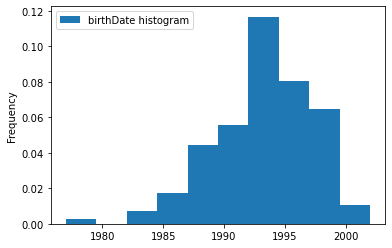

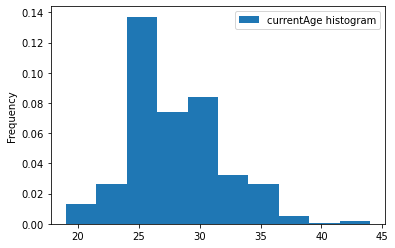

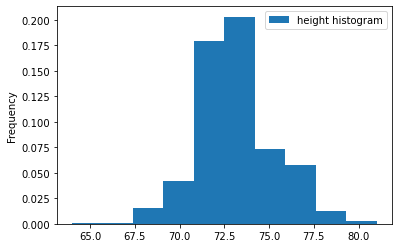

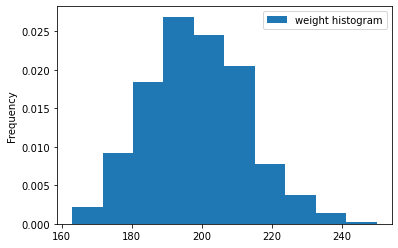

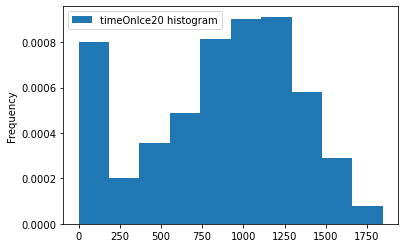

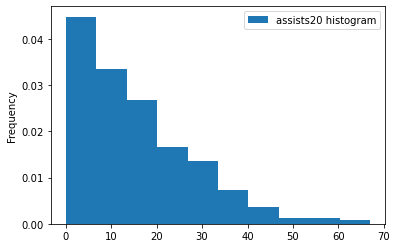

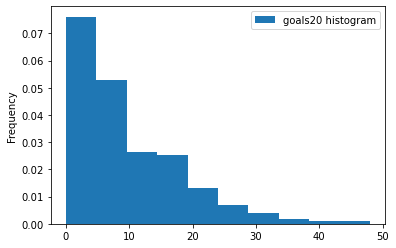

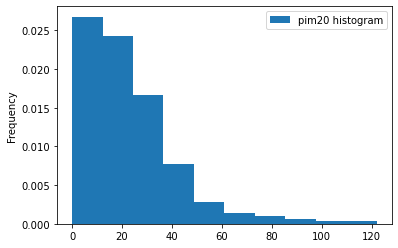

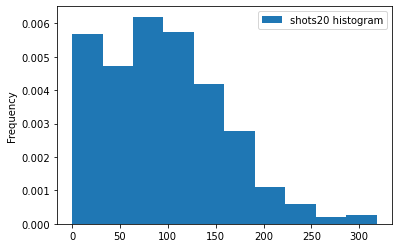

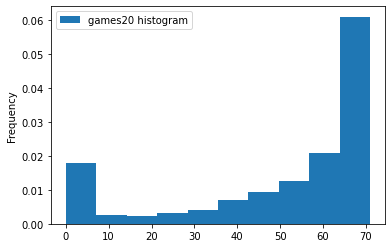

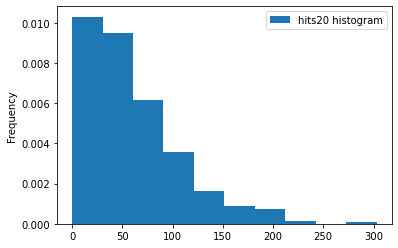

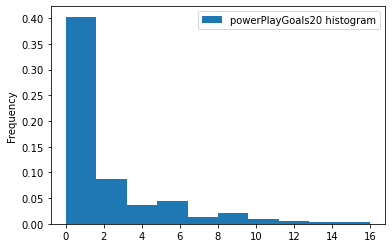

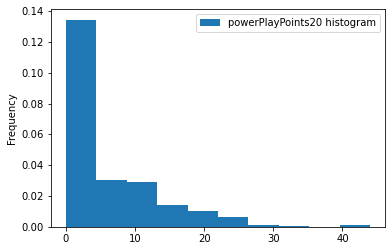

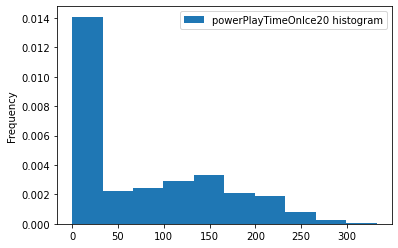

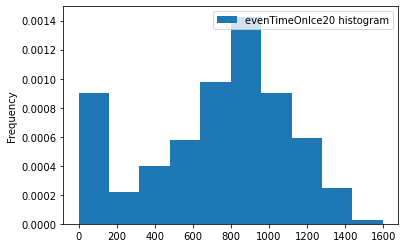

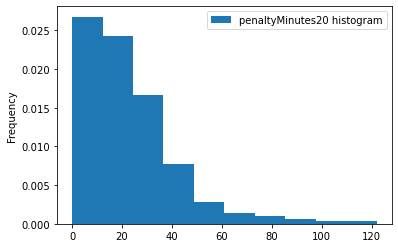

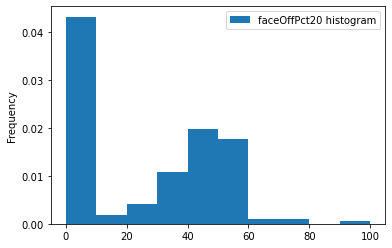

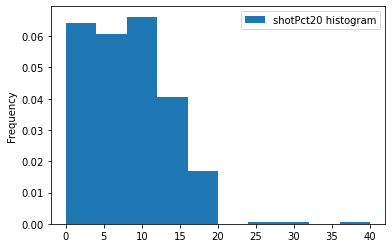

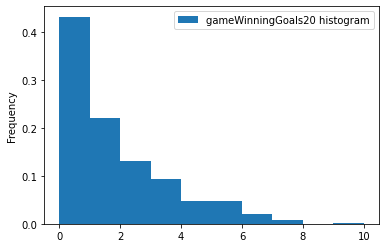

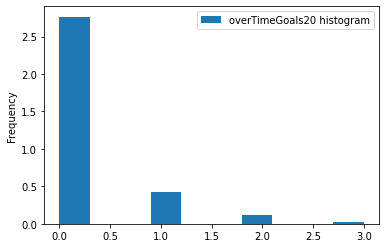

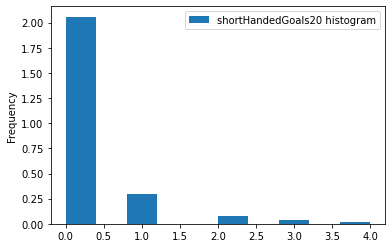

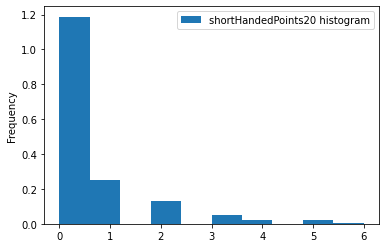

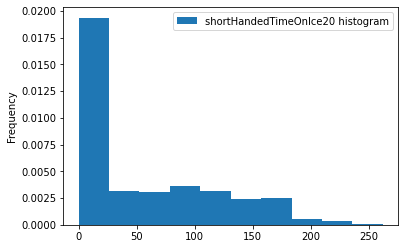

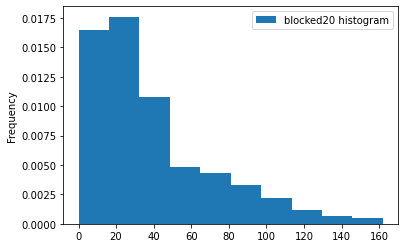

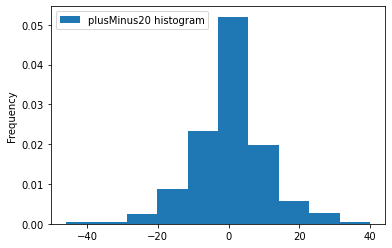

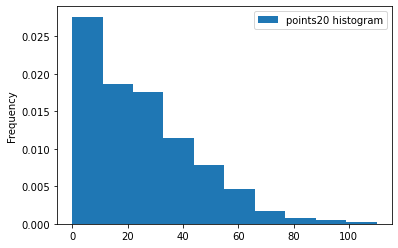

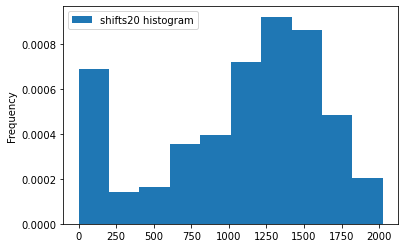

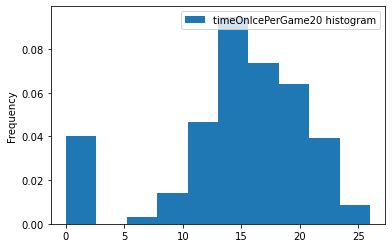

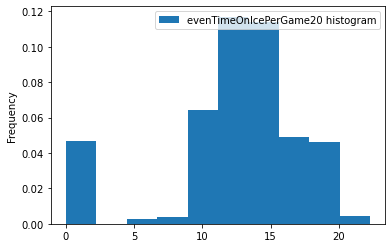

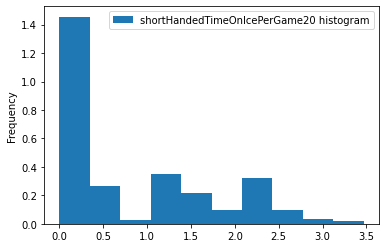

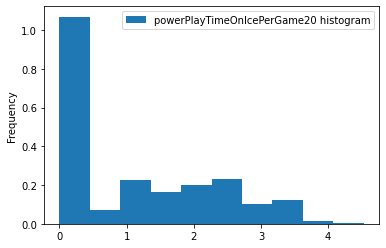

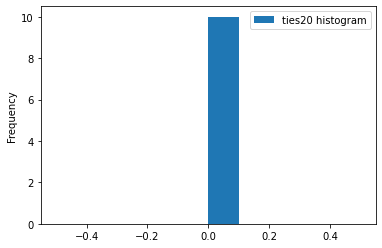

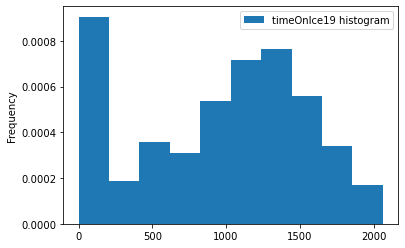

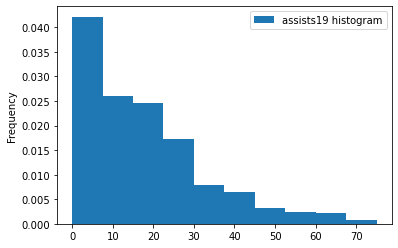

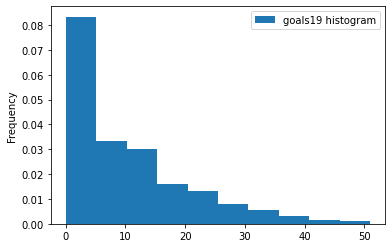

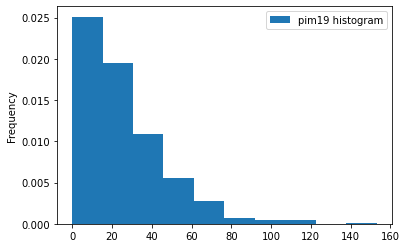

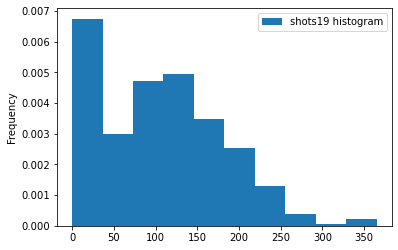

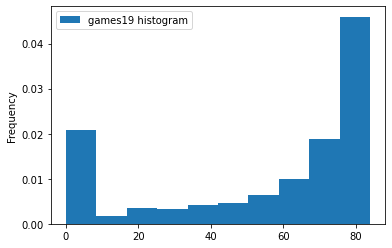

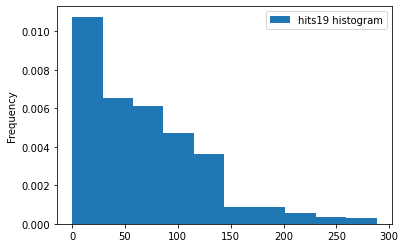

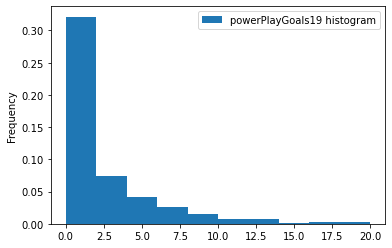

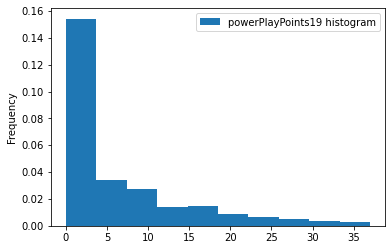

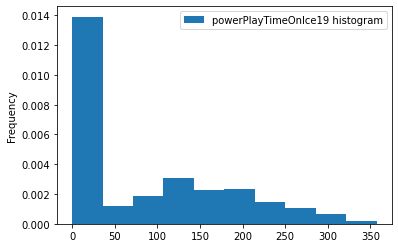

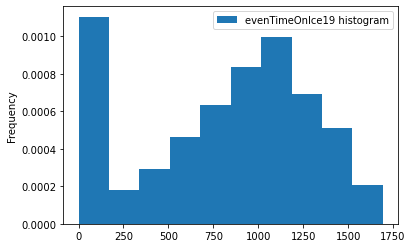

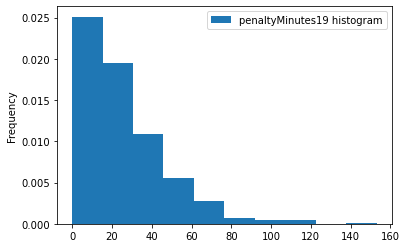

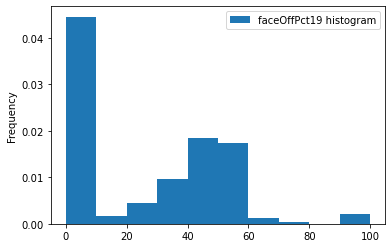

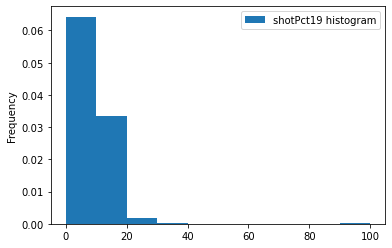

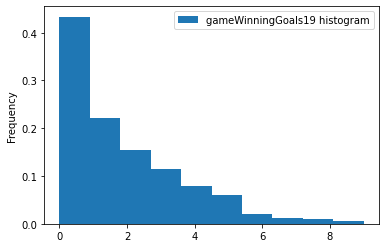

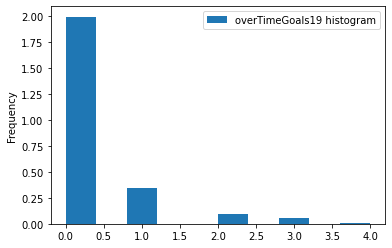

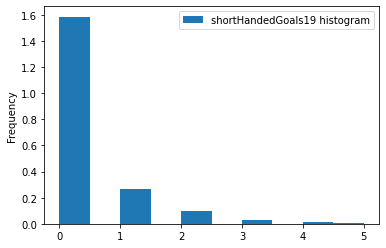

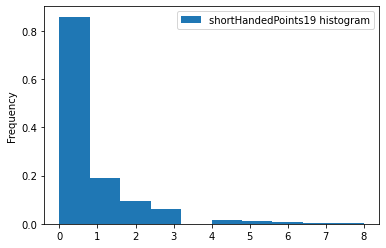

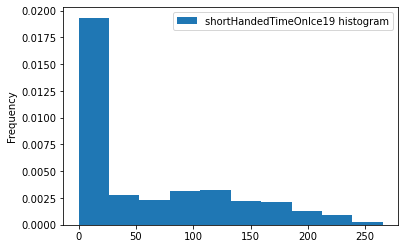

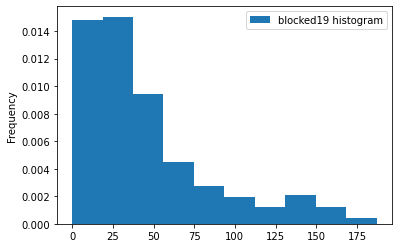

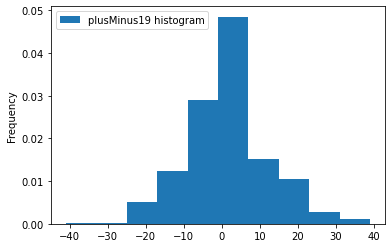

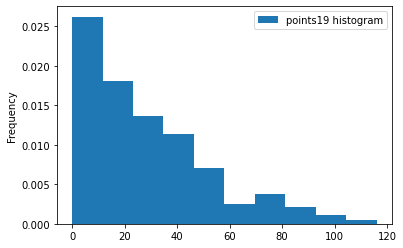

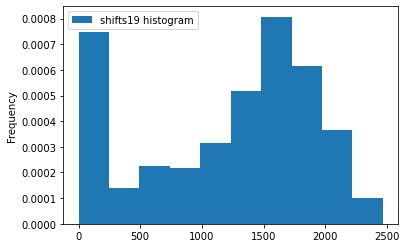

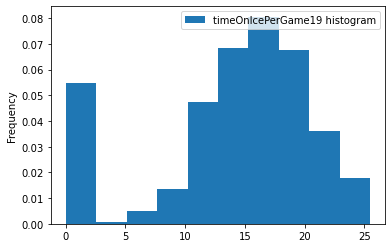

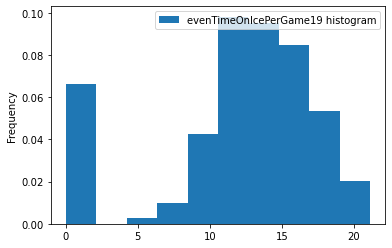

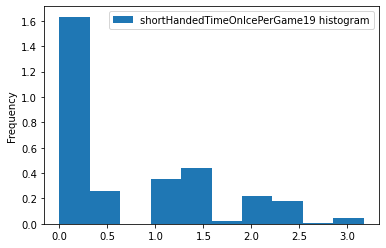

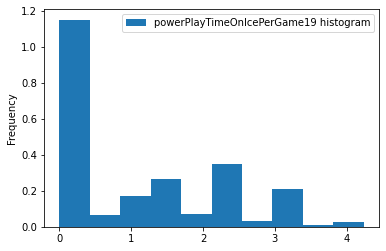

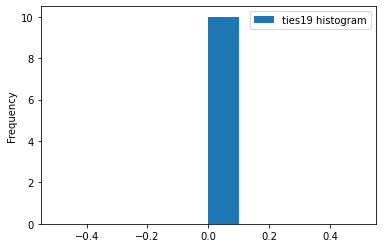

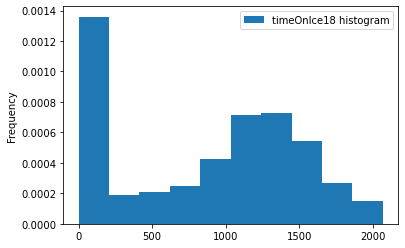

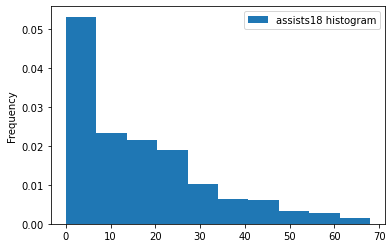

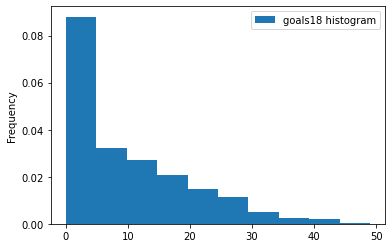

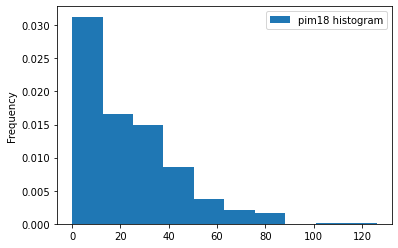

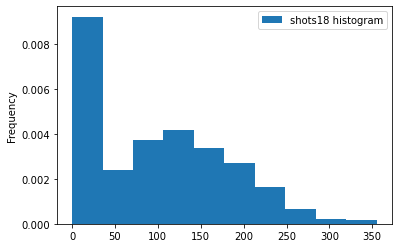

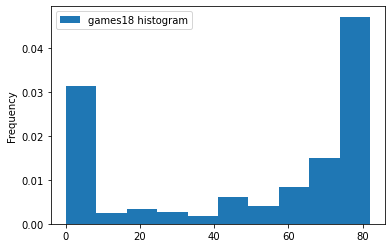

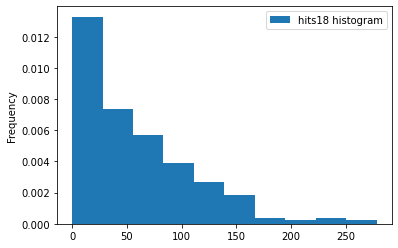

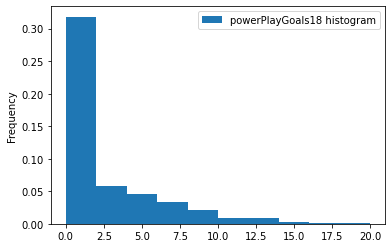

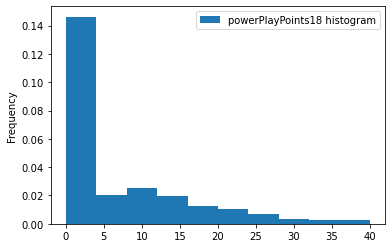

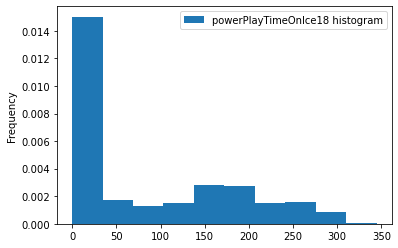

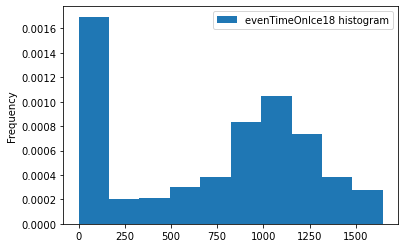

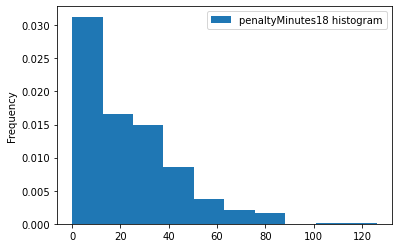

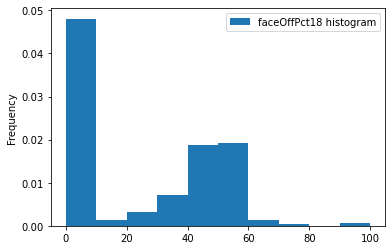

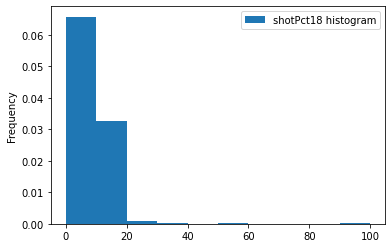

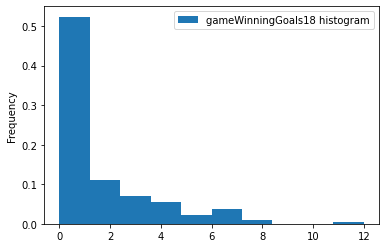

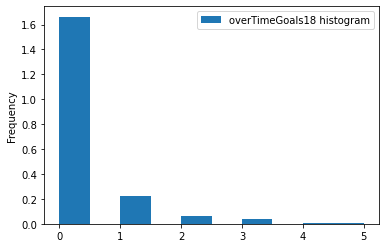

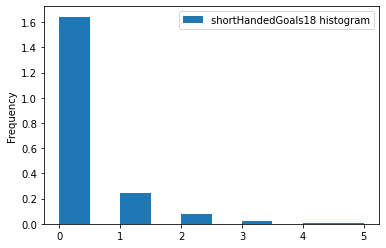

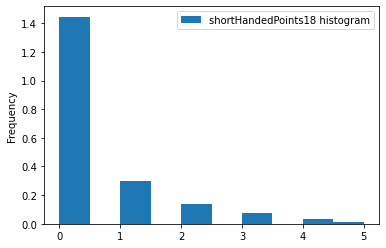

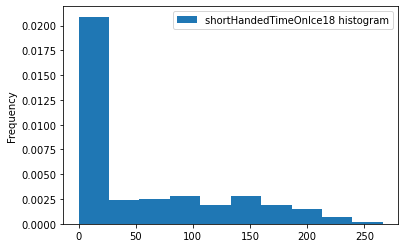

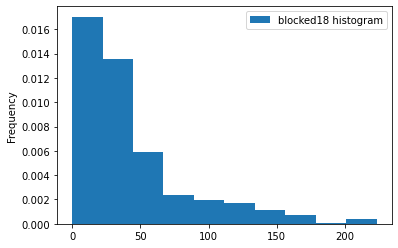

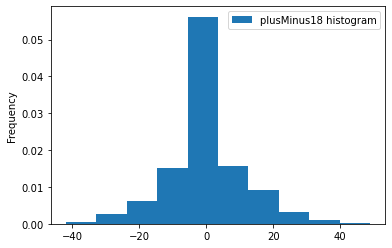

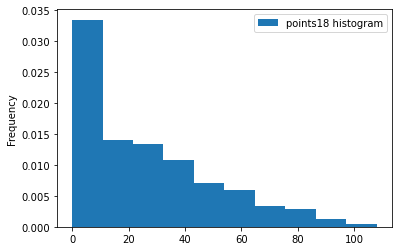

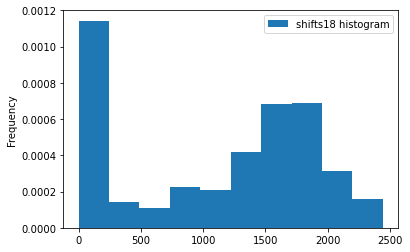

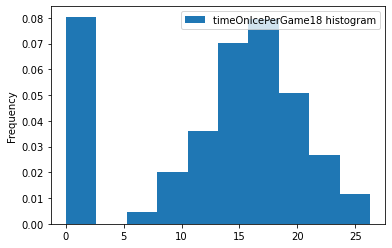

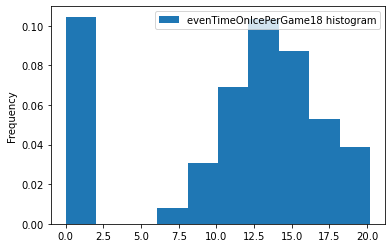

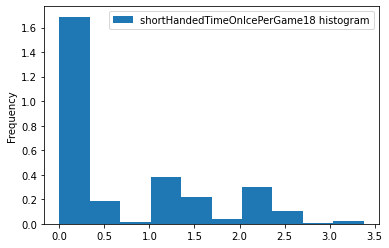

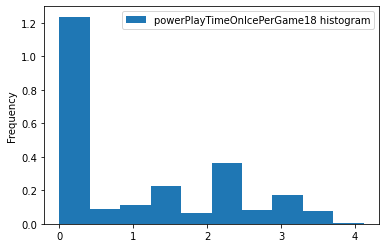

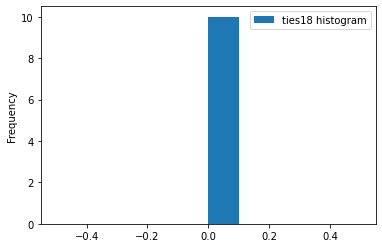

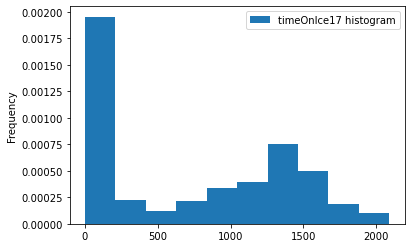

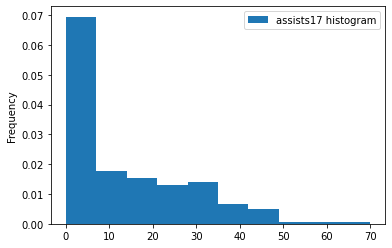

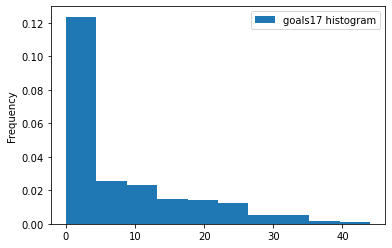

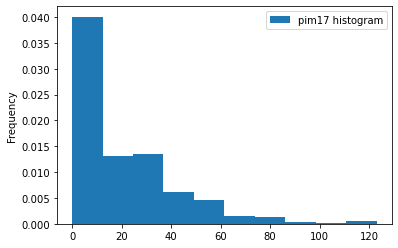

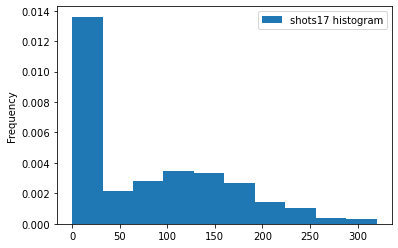

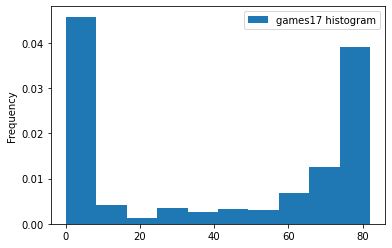

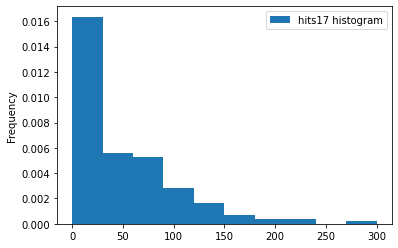

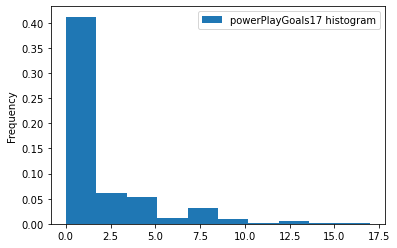

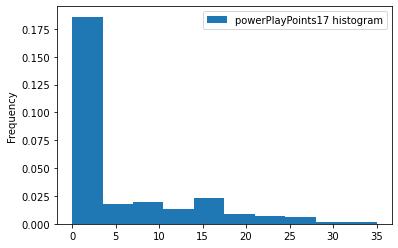

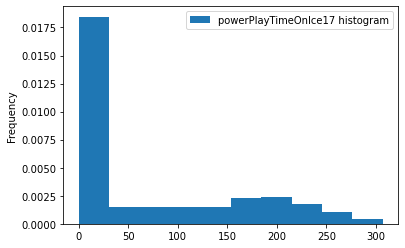

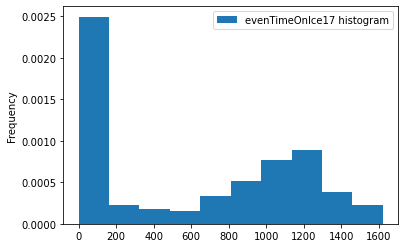

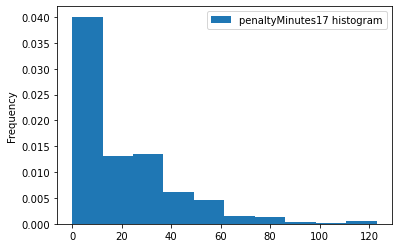

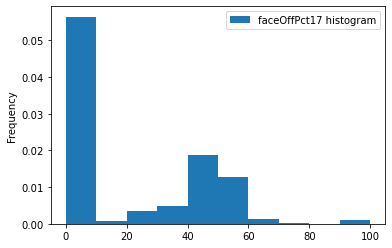

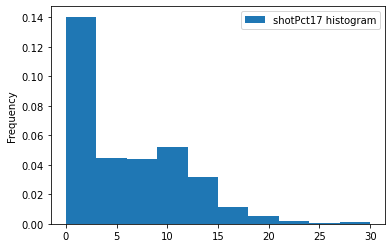

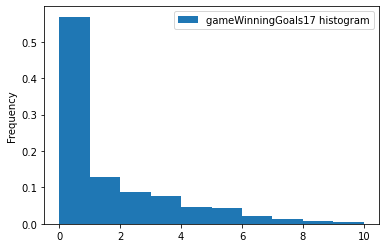

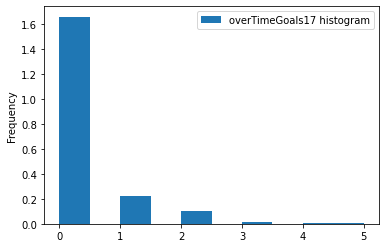

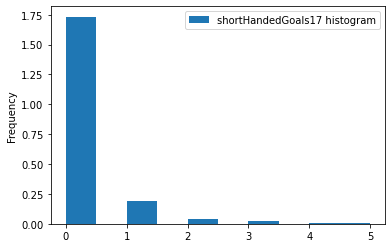

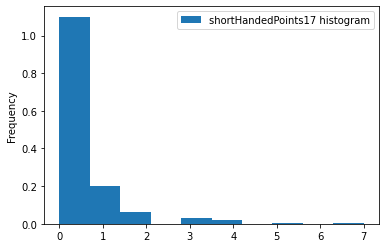

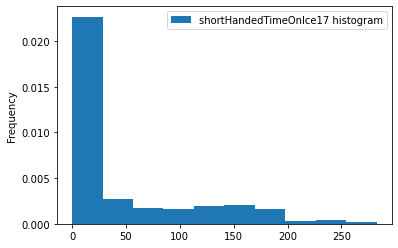

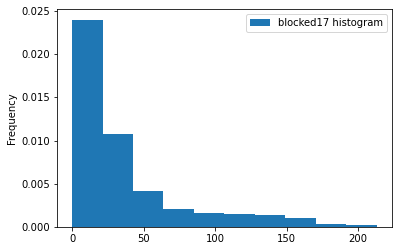

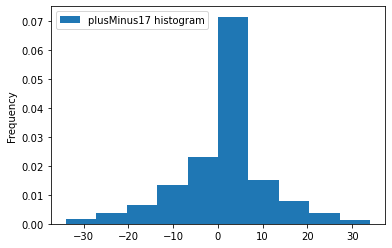

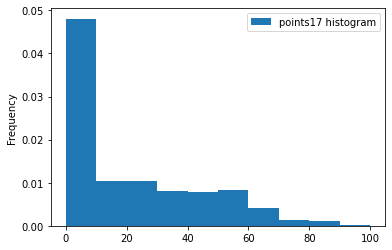

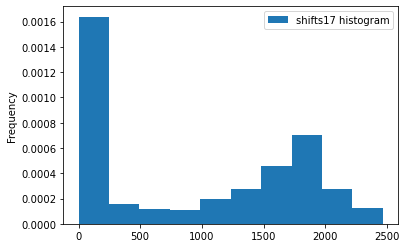

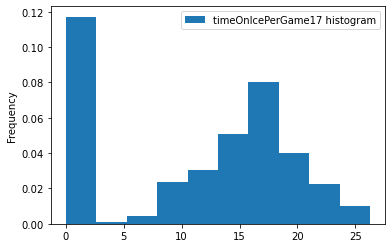

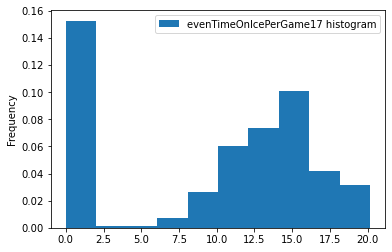

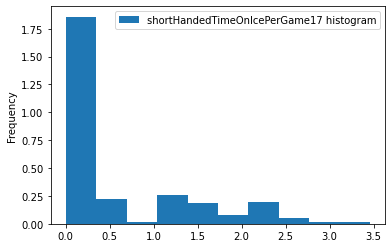

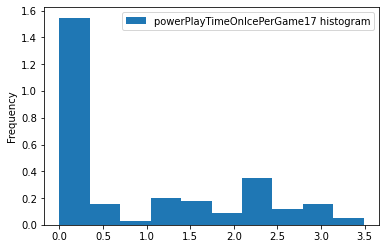

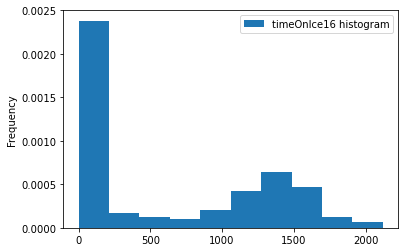

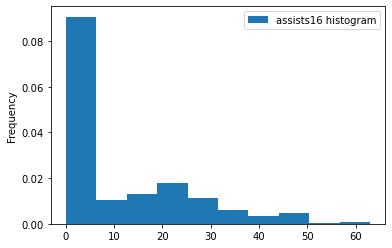

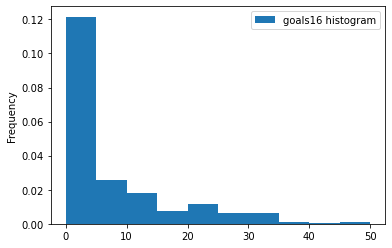

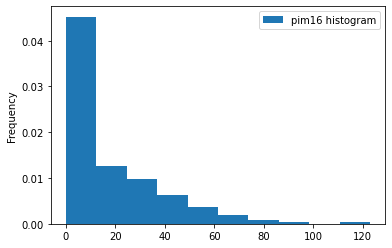

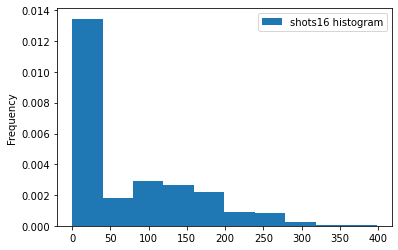

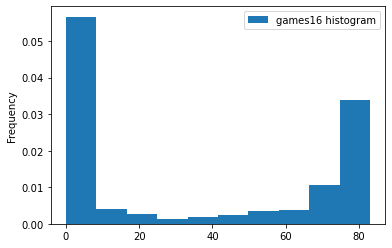

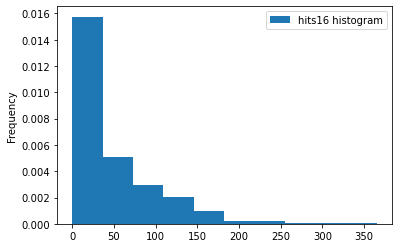

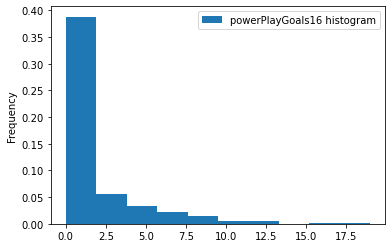

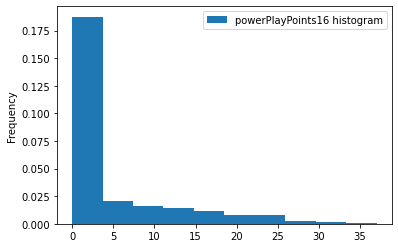

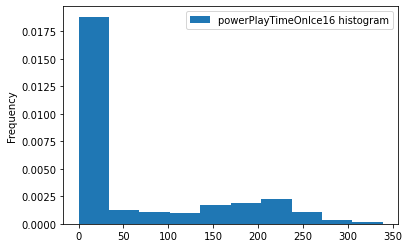

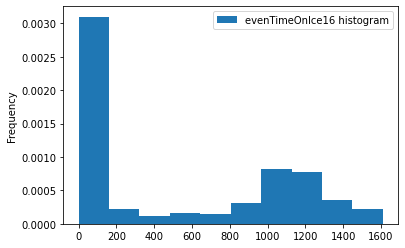

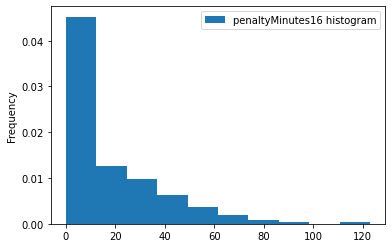

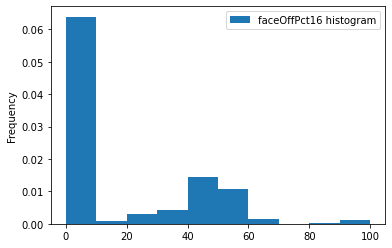

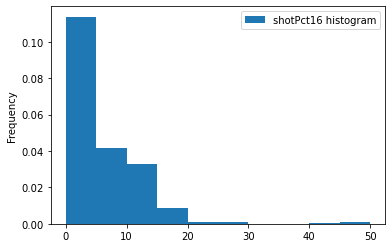

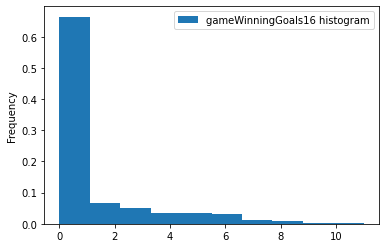

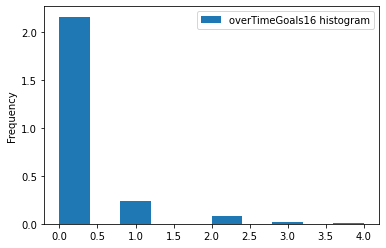

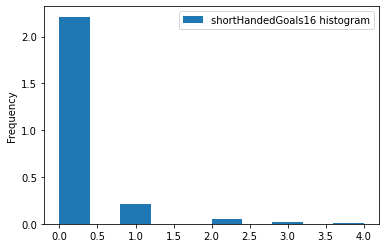

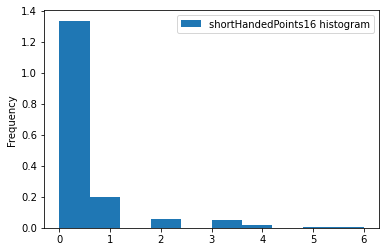

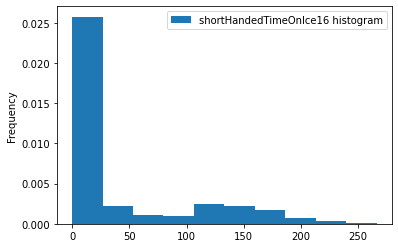

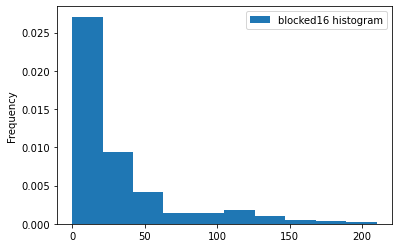

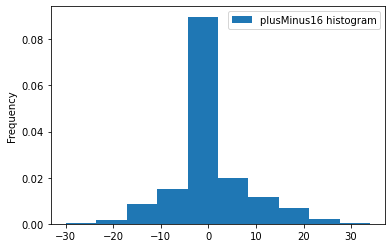

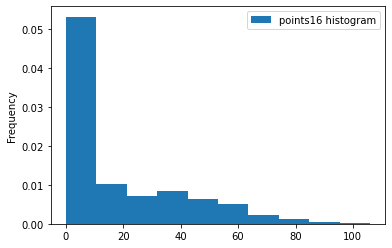

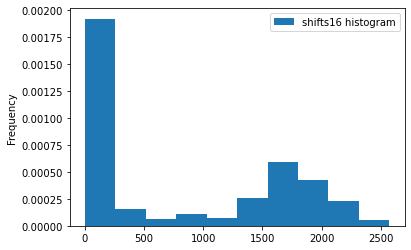

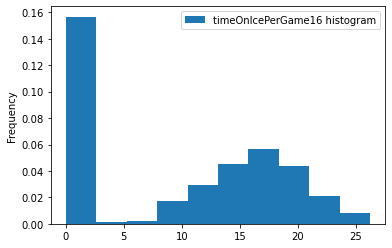

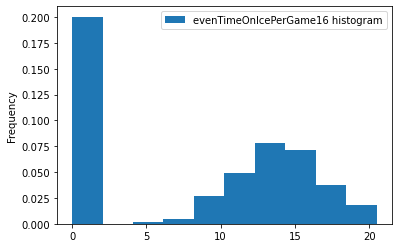

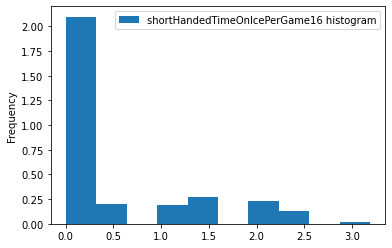

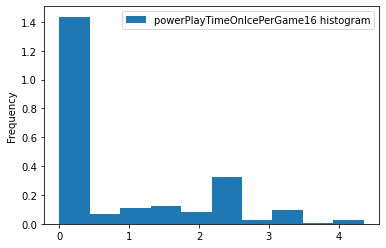

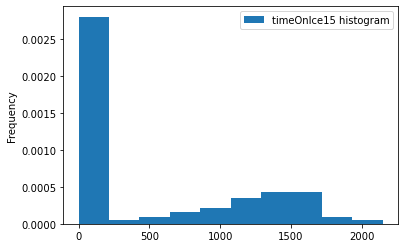

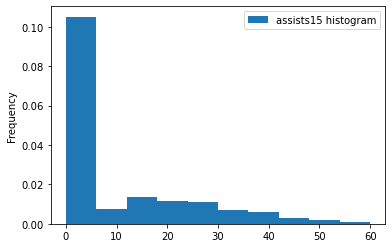

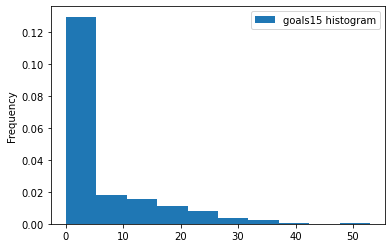

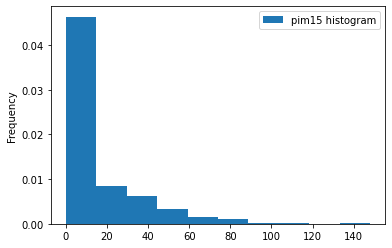

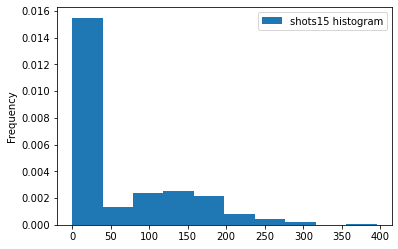

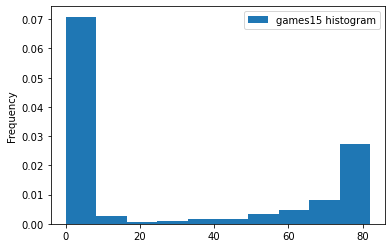

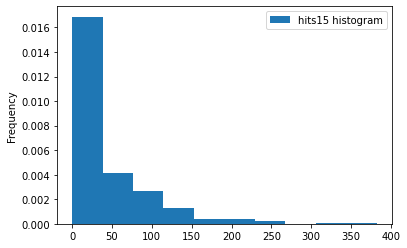

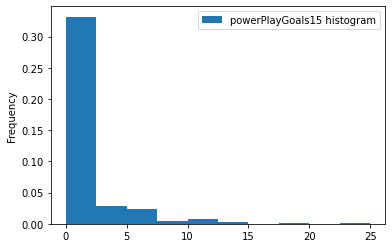

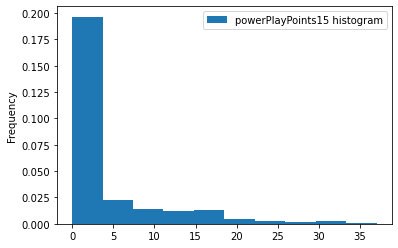

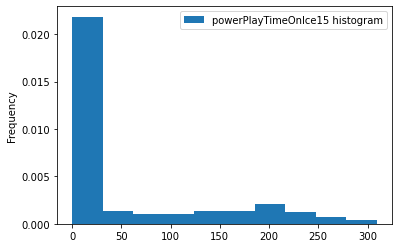

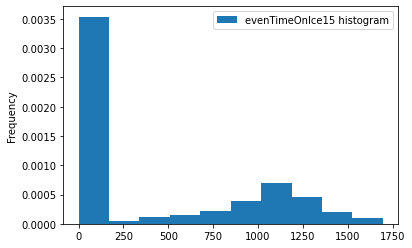

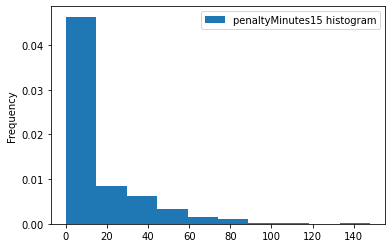

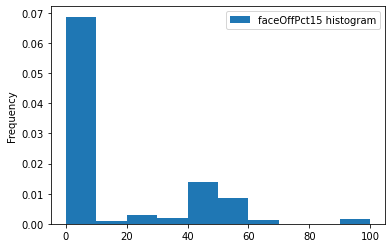

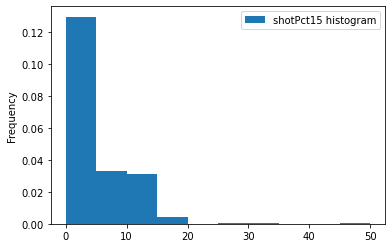

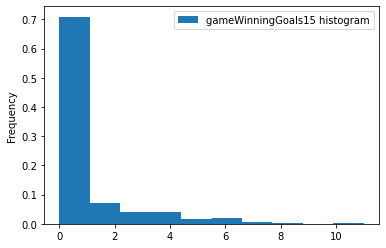

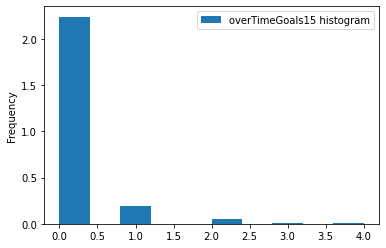

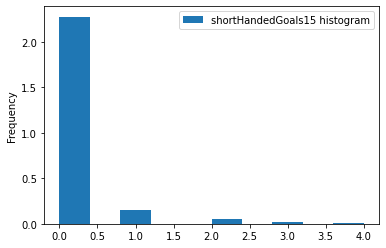

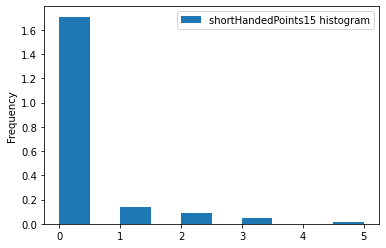

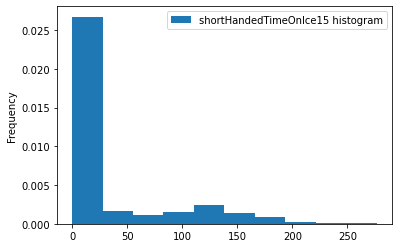

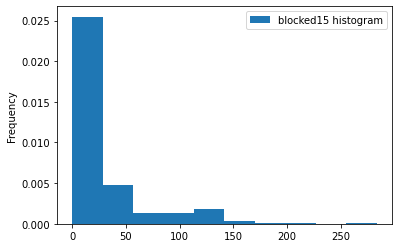

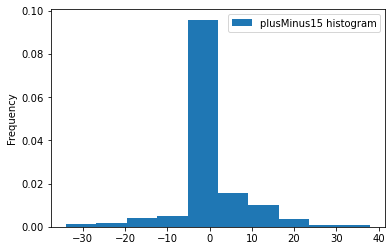

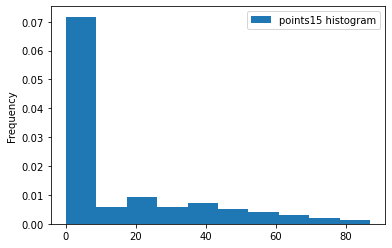

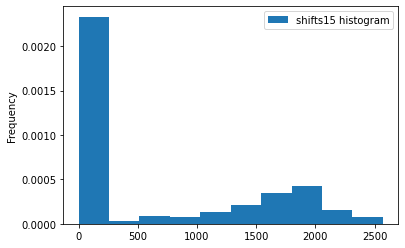

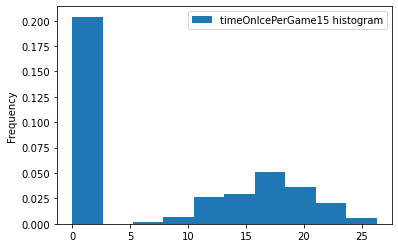

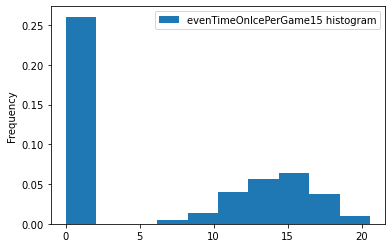

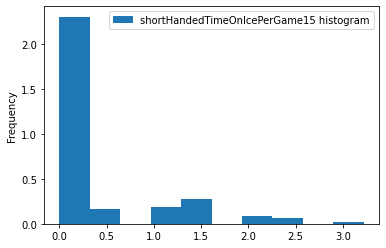

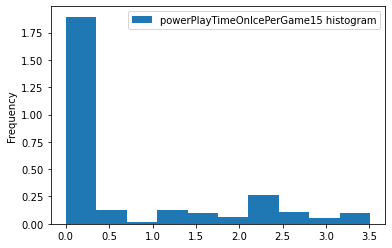

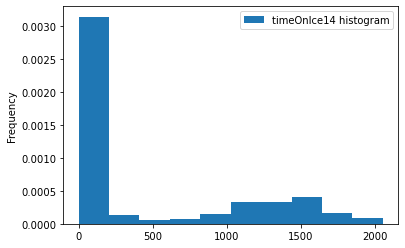

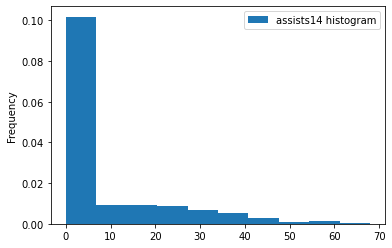

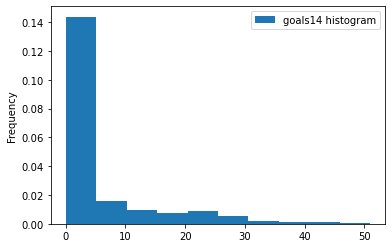

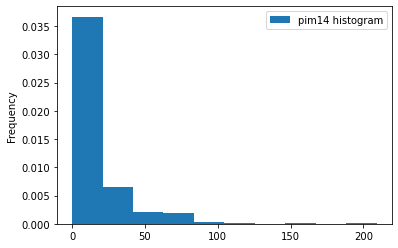

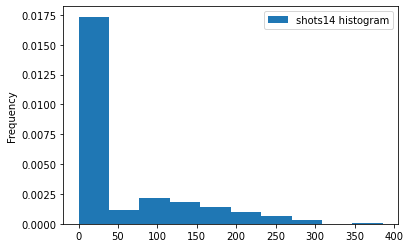

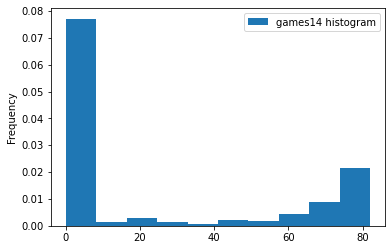

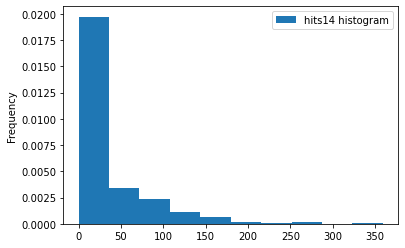

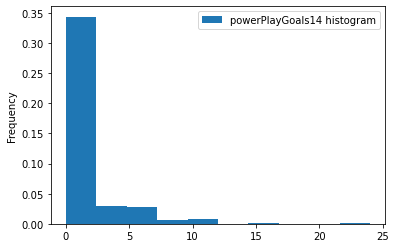

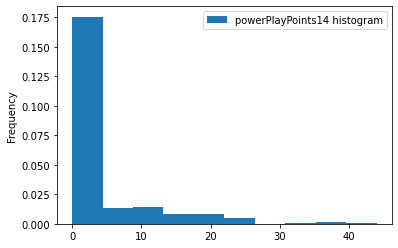

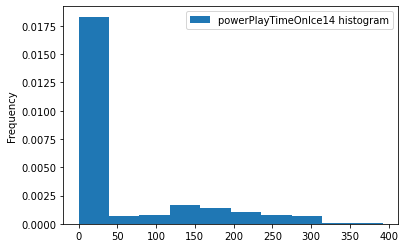

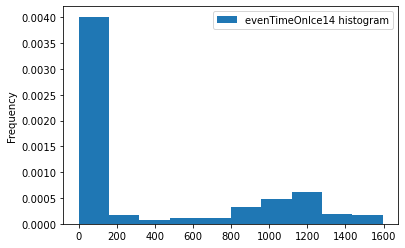

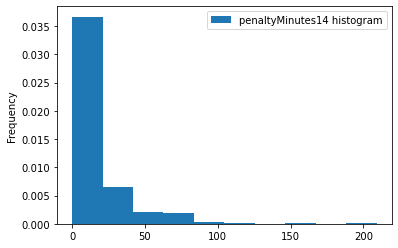

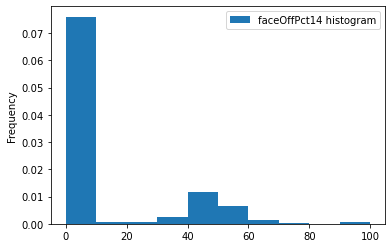

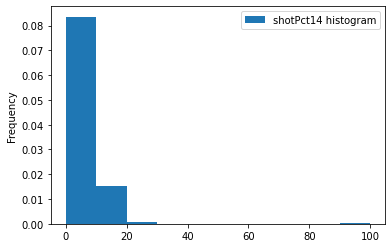

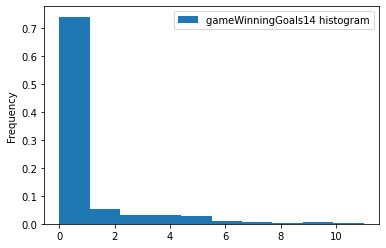

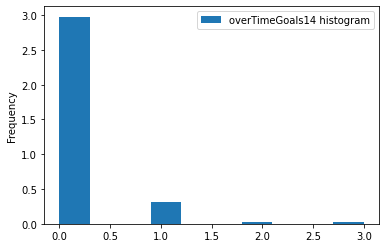

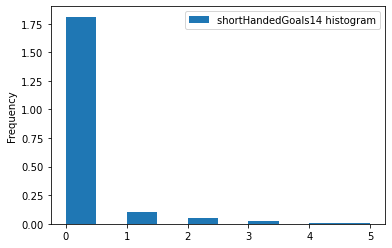

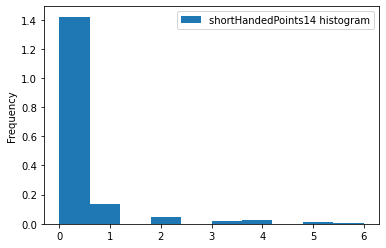

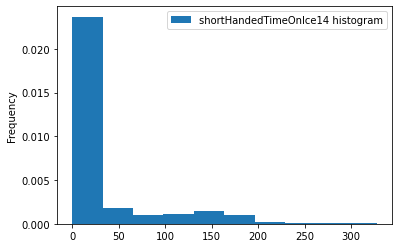

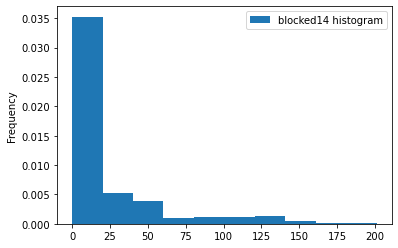

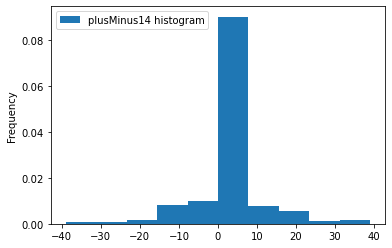

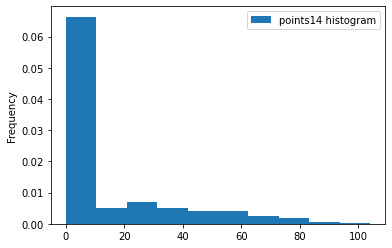

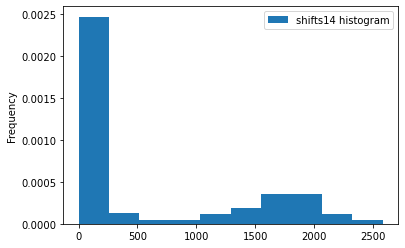

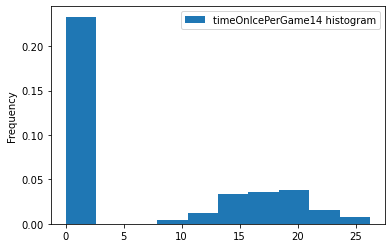

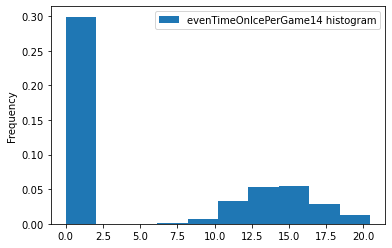

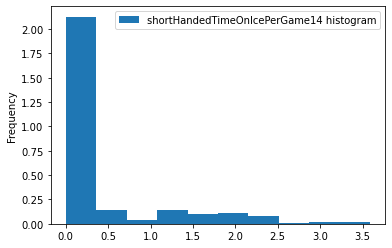

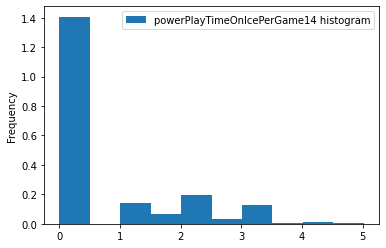

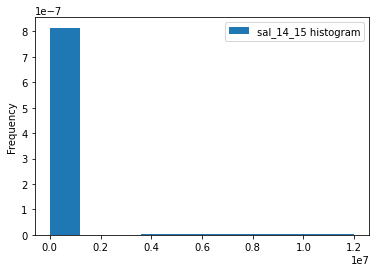

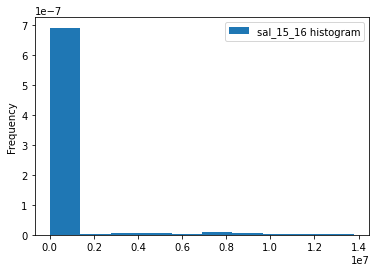

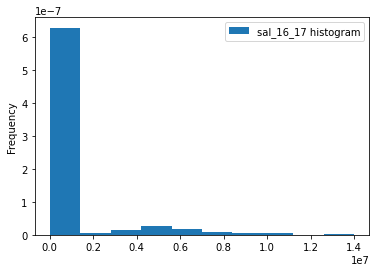

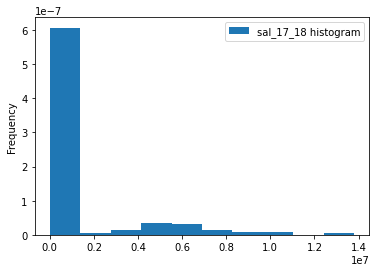

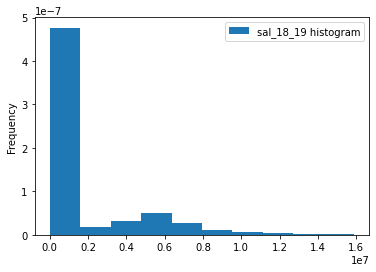

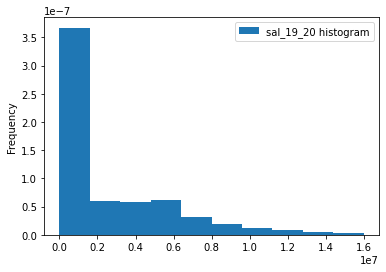

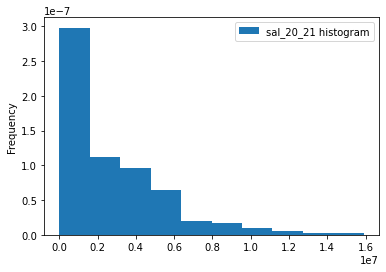

In [81]:
df_no_cats = df.drop(df_cat_cols, axis=1)

for column in df_no_cats.columns:
    df_no_cats[column].plot.hist(density=True, label = column+' histogram')
    plt.legend()
    plt.show()

### Reviewing the above charts we can see that our data is not normally distributed and we will need to incorporatre some form a scaling. Also, we have blank graphs for ties18, ties19, and ties20. Lets see what these columns are. 

In [70]:
df_no_cats['ties18'].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [71]:
df_no_cats['ties19'].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Thats a whole lot of NaN's. My assumption is that these are tied to the goalies which we dropped earlier. We will move forward dropping these columns as they serve no purpose.

In [82]:
df.drop(['ties20', 'ties19', 'ties18'], axis=1, inplace=True)

### Next lets get create a Linear Regression model with only our numerical features (no categoricals). 

In [87]:
df_no_cats = df.drop(df_cat_cols, axis=1)

X = df_no_cats.drop('sal_20_21', axis=1)
y = df_no_cats['sal_20_21']

numeric_features = ['birthDate',
                     'currentAge',
                     'height',
                     'weight',
                     'timeOnIce20',
                     'assists20',
                     'goals20',
                     'pim20',
                     'shots20',
                     'games20',
                     'hits20',
                     'powerPlayGoals20',
                     'powerPlayPoints20',
                     'powerPlayTimeOnIce20',
                     'evenTimeOnIce20',
                     'penaltyMinutes20',
                     'faceOffPct20',
                     'shotPct20',
                     'gameWinningGoals20',
                     'overTimeGoals20',
                     'shortHandedGoals20',
                     'shortHandedPoints20',
                     'shortHandedTimeOnIce20',
                     'blocked20',
                     'plusMinus20',
                     'points20',
                     'shifts20',
                     'timeOnIcePerGame20',
                     'evenTimeOnIcePerGame20',
                     'shortHandedTimeOnIcePerGame20',
                     'powerPlayTimeOnIcePerGame20',
                     'timeOnIce19',
                     'assists19',
                     'goals19',
                     'pim19',
                     'shots19',
                     'games19',
                     'hits19',
                     'powerPlayGoals19',
                     'powerPlayPoints19',
                     'powerPlayTimeOnIce19',
                     'evenTimeOnIce19',
                     'penaltyMinutes19',
                     'faceOffPct19',
                     'shotPct19',
                     'gameWinningGoals19',
                     'overTimeGoals19',
                     'shortHandedGoals19',
                     'shortHandedPoints19',
                     'shortHandedTimeOnIce19',
                     'blocked19',
                     'plusMinus19',
                     'points19',
                     'shifts19',
                     'timeOnIcePerGame19',
                     'evenTimeOnIcePerGame19',
                     'shortHandedTimeOnIcePerGame19',
                     'powerPlayTimeOnIcePerGame19',
                     'timeOnIce18',
                     'assists18',
                     'goals18',
                     'pim18',
                     'shots18',
                     'games18',
                     'hits18',
                     'powerPlayGoals18',
                     'powerPlayPoints18',
                     'powerPlayTimeOnIce18',
                     'evenTimeOnIce18',
                     'penaltyMinutes18',
                     'faceOffPct18',
                     'shotPct18',
                     'gameWinningGoals18',
                     'overTimeGoals18',
                     'shortHandedGoals18',
                     'shortHandedPoints18',
                     'shortHandedTimeOnIce18',
                     'blocked18',
                     'plusMinus18',
                     'points18',
                     'shifts18',
                     'timeOnIcePerGame18',
                     'evenTimeOnIcePerGame18',
                     'shortHandedTimeOnIcePerGame18',
                     'powerPlayTimeOnIcePerGame18',
                     'timeOnIce17',
                     'assists17',
                     'goals17',
                     'pim17',
                     'shots17',
                     'games17',
                     'hits17',
                     'powerPlayGoals17',
                     'powerPlayPoints17',
                     'powerPlayTimeOnIce17',
                     'evenTimeOnIce17',
                     'penaltyMinutes17',
                     'faceOffPct17',
                     'shotPct17',
                     'gameWinningGoals17',
                     'overTimeGoals17',
                     'shortHandedGoals17',
                     'shortHandedPoints17',
                     'shortHandedTimeOnIce17',
                     'blocked17',
                     'plusMinus17',
                     'points17',
                     'shifts17',
                     'timeOnIcePerGame17',
                     'evenTimeOnIcePerGame17',
                     'shortHandedTimeOnIcePerGame17',
                     'powerPlayTimeOnIcePerGame17',
                     'timeOnIce16',
                     'assists16',
                     'goals16',
                     'pim16',
                     'shots16',
                     'games16',
                     'hits16',
                     'powerPlayGoals16',
                     'powerPlayPoints16',
                     'powerPlayTimeOnIce16',
                     'evenTimeOnIce16',
                     'penaltyMinutes16',
                     'faceOffPct16',
                     'shotPct16',
                     'gameWinningGoals16',
                     'overTimeGoals16',
                     'shortHandedGoals16',
                     'shortHandedPoints16',
                     'shortHandedTimeOnIce16',
                     'blocked16',
                     'plusMinus16',
                     'points16',
                     'shifts16',
                     'timeOnIcePerGame16',
                     'evenTimeOnIcePerGame16',
                     'shortHandedTimeOnIcePerGame16',
                     'powerPlayTimeOnIcePerGame16',
                     'timeOnIce15',
                     'assists15',
                     'goals15',
                     'pim15',
                     'shots15',
                     'games15',
                     'hits15',
                     'powerPlayGoals15',
                     'powerPlayPoints15',
                     'powerPlayTimeOnIce15',
                     'evenTimeOnIce15',
                     'penaltyMinutes15',
                     'faceOffPct15',
                     'shotPct15',
                     'gameWinningGoals15',
                     'overTimeGoals15',
                     'shortHandedGoals15',
                     'shortHandedPoints15',
                     'shortHandedTimeOnIce15',
                     'blocked15',
                     'plusMinus15',
                     'points15',
                     'shifts15',
                     'timeOnIcePerGame15',
                     'evenTimeOnIcePerGame15',
                     'shortHandedTimeOnIcePerGame15',
                     'powerPlayTimeOnIcePerGame15',
                     'timeOnIce14',
                     'assists14',
                     'goals14',
                     'pim14',
                     'shots14',
                     'games14',
                     'hits14',
                     'powerPlayGoals14',
                     'powerPlayPoints14',
                     'powerPlayTimeOnIce14',
                     'evenTimeOnIce14',
                     'penaltyMinutes14',
                     'faceOffPct14',
                     'shotPct14',
                     'gameWinningGoals14',
                     'overTimeGoals14',
                     'shortHandedGoals14',
                     'shortHandedPoints14',
                     'shortHandedTimeOnIce14',
                     'blocked14',
                     'plusMinus14',
                     'points14',
                     'shifts14',
                     'timeOnIcePerGame14',
                     'evenTimeOnIcePerGame14',
                     'shortHandedTimeOnIcePerGame14',
                     'powerPlayTimeOnIcePerGame14',
                     'sal_14_15',
                     'sal_15_16',
                     'sal_16_17',
                     'sal_17_18',
                     'sal_18_19',
                     'sal_19_20']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)


clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.379


### With a score of 0.379, we definitely have room for improvement. Lets see what happens is we add in our categorical variables. 

In [90]:
X = df.drop('sal_20_21', axis=1)
y = df['sal_20_21']

numeric_features = ['birthDate',
                     'currentAge',
                     'height',
                     'weight',
                     'timeOnIce20',
                     'assists20',
                     'goals20',
                     'pim20',
                     'shots20',
                     'games20',
                     'hits20',
                     'powerPlayGoals20',
                     'powerPlayPoints20',
                     'powerPlayTimeOnIce20',
                     'evenTimeOnIce20',
                     'penaltyMinutes20',
                     'faceOffPct20',
                     'shotPct20',
                     'gameWinningGoals20',
                     'overTimeGoals20',
                     'shortHandedGoals20',
                     'shortHandedPoints20',
                     'shortHandedTimeOnIce20',
                     'blocked20',
                     'plusMinus20',
                     'points20',
                     'shifts20',
                     'timeOnIcePerGame20',
                     'evenTimeOnIcePerGame20',
                     'shortHandedTimeOnIcePerGame20',
                     'powerPlayTimeOnIcePerGame20',
                     'timeOnIce19',
                     'assists19',
                     'goals19',
                     'pim19',
                     'shots19',
                     'games19',
                     'hits19',
                     'powerPlayGoals19',
                     'powerPlayPoints19',
                     'powerPlayTimeOnIce19',
                     'evenTimeOnIce19',
                     'penaltyMinutes19',
                     'faceOffPct19',
                     'shotPct19',
                     'gameWinningGoals19',
                     'overTimeGoals19',
                     'shortHandedGoals19',
                     'shortHandedPoints19',
                     'shortHandedTimeOnIce19',
                     'blocked19',
                     'plusMinus19',
                     'points19',
                     'shifts19',
                     'timeOnIcePerGame19',
                     'evenTimeOnIcePerGame19',
                     'shortHandedTimeOnIcePerGame19',
                     'powerPlayTimeOnIcePerGame19',
                     'timeOnIce18',
                     'assists18',
                     'goals18',
                     'pim18',
                     'shots18',
                     'games18',
                     'hits18',
                     'powerPlayGoals18',
                     'powerPlayPoints18',
                     'powerPlayTimeOnIce18',
                     'evenTimeOnIce18',
                     'penaltyMinutes18',
                     'faceOffPct18',
                     'shotPct18',
                     'gameWinningGoals18',
                     'overTimeGoals18',
                     'shortHandedGoals18',
                     'shortHandedPoints18',
                     'shortHandedTimeOnIce18',
                     'blocked18',
                     'plusMinus18',
                     'points18',
                     'shifts18',
                     'timeOnIcePerGame18',
                     'evenTimeOnIcePerGame18',
                     'shortHandedTimeOnIcePerGame18',
                     'powerPlayTimeOnIcePerGame18',
                     'timeOnIce17',
                     'assists17',
                     'goals17',
                     'pim17',
                     'shots17',
                     'games17',
                     'hits17',
                     'powerPlayGoals17',
                     'powerPlayPoints17',
                     'powerPlayTimeOnIce17',
                     'evenTimeOnIce17',
                     'penaltyMinutes17',
                     'faceOffPct17',
                     'shotPct17',
                     'gameWinningGoals17',
                     'overTimeGoals17',
                     'shortHandedGoals17',
                     'shortHandedPoints17',
                     'shortHandedTimeOnIce17',
                     'blocked17',
                     'plusMinus17',
                     'points17',
                     'shifts17',
                     'timeOnIcePerGame17',
                     'evenTimeOnIcePerGame17',
                     'shortHandedTimeOnIcePerGame17',
                     'powerPlayTimeOnIcePerGame17',
                     'timeOnIce16',
                     'assists16',
                     'goals16',
                     'pim16',
                     'shots16',
                     'games16',
                     'hits16',
                     'powerPlayGoals16',
                     'powerPlayPoints16',
                     'powerPlayTimeOnIce16',
                     'evenTimeOnIce16',
                     'penaltyMinutes16',
                     'faceOffPct16',
                     'shotPct16',
                     'gameWinningGoals16',
                     'overTimeGoals16',
                     'shortHandedGoals16',
                     'shortHandedPoints16',
                     'shortHandedTimeOnIce16',
                     'blocked16',
                     'plusMinus16',
                     'points16',
                     'shifts16',
                     'timeOnIcePerGame16',
                     'evenTimeOnIcePerGame16',
                     'shortHandedTimeOnIcePerGame16',
                     'powerPlayTimeOnIcePerGame16',
                     'timeOnIce15',
                     'assists15',
                     'goals15',
                     'pim15',
                     'shots15',
                     'games15',
                     'hits15',
                     'powerPlayGoals15',
                     'powerPlayPoints15',
                     'powerPlayTimeOnIce15',
                     'evenTimeOnIce15',
                     'penaltyMinutes15',
                     'faceOffPct15',
                     'shotPct15',
                     'gameWinningGoals15',
                     'overTimeGoals15',
                     'shortHandedGoals15',
                     'shortHandedPoints15',
                     'shortHandedTimeOnIce15',
                     'blocked15',
                     'plusMinus15',
                     'points15',
                     'shifts15',
                     'timeOnIcePerGame15',
                     'evenTimeOnIcePerGame15',
                     'shortHandedTimeOnIcePerGame15',
                     'powerPlayTimeOnIcePerGame15',
                     'timeOnIce14',
                     'assists14',
                     'goals14',
                     'pim14',
                     'shots14',
                     'games14',
                     'hits14',
                     'powerPlayGoals14',
                     'powerPlayPoints14',
                     'powerPlayTimeOnIce14',
                     'evenTimeOnIce14',
                     'penaltyMinutes14',
                     'faceOffPct14',
                     'shotPct14',
                     'gameWinningGoals14',
                     'overTimeGoals14',
                     'shortHandedGoals14',
                     'shortHandedPoints14',
                     'shortHandedTimeOnIce14',
                     'blocked14',
                     'plusMinus14',
                     'points14',
                     'shifts14',
                     'timeOnIcePerGame14',
                     'evenTimeOnIcePerGame14',
                     'shortHandedTimeOnIcePerGame14',
                     'powerPlayTimeOnIcePerGame14',
                     'sal_14_15',
                     'sal_15_16',
                     'sal_16_17',
                     'sal_17_18',
                     'sal_18_19',
                     'sal_19_20']

numeric_transformer = Pipeline(steps=[
                                ('scaler', StandardScaler())])

categorical_features = ['name',
                         'birthCity',
                         'birthStateProvince',
                         'birthCountry',
                         'alternateCaptain',
                         'captain',
                         'rookie',
                         'shootsCatches',
                         'rosterStatus']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

ValueError: A given column is not a column of the dataframe

In [ ]:
for column in less_than_05:
    less_than_05[column].plot.hist(density=True, label = column+' histogram')
    less_than_05[column].plot.kde(label =column+' kde')
    plt.legend()
    plt.show()

In [ ]:
less_than_05.columns.tolist()

In [ ]:
X = less_than_05.drop('sal_20_21', axis=1)
y = less_than_05['sal_20_21']

numeric_features = [ 'games20',
 'gameWinningGoals20',
 'overTimeGoals20',
 'evenTimeOnIcePerGame18',
 'powerPlayTimeOnIce18',
 'assists17',
 'pim17',
 'penaltyMinutes17',
 'shortHandedGoals17',
 'powerPlayGoals16',
 'blocked17']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# categorical_features = ['embarked', 'sex', 'pclass']
# categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])
#         ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)


clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

In [ ]:
df[df_cat_cols] = df[df_cat_cols].astype(str)

less_than_05_w_cats = pd.concat([less_than_05, df[df_cat_cols]], axis=1)

less_than_05_w_cats = less_than_05_w_cats.drop(['fullName', 'birthCity'], axis=1)

less_than_05_w_cats

In [ ]:
less_than_05_w_cats.info()

In [ ]:
X = less_than_05_w_cats.drop('sal_20_21', axis=1)
y = less_than_05_w_cats['sal_20_21']

numeric_features = [ 'games20',
 'gameWinningGoals20',
 'overTimeGoals20',
 'evenTimeOnIcePerGame18',
 'powerPlayTimeOnIce18',
 'assists17',
 'pim17',
 'penaltyMinutes17',
 'shortHandedGoals17',
 'powerPlayGoals16',
 'blocked17']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['birthStateProvince', 'birthCountry',\
               'alternateCaptain', 'captain', 'rookie', 'shootsCatches',\
               'rosterStatus']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)


clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

# Summing redundant columns

In [ ]:
redundant = ['timeOnIce',
 'assists',
 'goals',
 'pim',
 'shots',
 'games',
 'hits',
 'powerPlayGoals',
 'powerPlayPoints',
 'powerPlayTimeOnIce',
 'evenTimeOnIce',
 'penaltyMinutes',
 'faceOffPct',
 'shotPct',
 'gameWinningGoals',
 'overTimeGoals',
 'shortHandedGoals',
 'shortHandedPoints',
 'shortHandedTimeOnIce',
 'blocked',
 'plusMinus',
 'points',
 'shifts',
 'timeOnIcePerGame',
 'evenTimeOnIcePerGame',
 'shortHandedTimeOnIcePerGame',
 'powerPlayTimeOnIcePerGame']

redundant_cols = []

for year in years:
    for col in redundant:
        redundant_cols.append(f'{col}{year}')

In [ ]:
redundant_dict = {}

for num in range(0, 27):
    redundant_dict[num] = {}
    for i in range(num, len(redundant_cols), 27):
        redundant_dict[num][i] = redundant_cols[i]

In [ ]:
for num in range(0,27):
    val = redundant_dict[num].values()
    cum_stats = np.sum(df_no_cats[val],axis=1)
    df_no_cats[num] = pd.DataFrame(cum_stats)

In [ ]:
df_no_cats.rename(columns={0:'total_timeOnIce',
 1:'total_assists',
 2:'total_goals',
 3:'total_pim',
 4:'total_shots',
 5:'total_games',
 6:'total_hits',
 7:'total_powerPlayGoals',
 8:'total_powerPlayPoints',
 9:'total_powerPlayTimeOnIce',
 10:'total_evenTimeOnIce',
 11:'total_penaltyMinutes',
 12:'total_faceOffPct',
 13:'total_shotPct',
 14:'total_gameWinningGoals',
 15:'total_overTimeGoals',
 16:'total_shortHandedGoals',
 17:'total_shortHandedPoints',
 18:'total_shortHandedTimeOnIce',
 19:'total_blocked',
 20:'total_plusMinus',
 21:'total_points',
 22:'total_shifts',
 23:'total_timeOnIcePerGame',
 24:'total_evenTimeOnIcePerGame',
 25:'total_shortHandedTimeOnIcePerGame',
 26:'total_powerPlayTimeOnIcePerGame'}, inplace=True)

In [ ]:
cum_df = df_no_cats.drop(redundant_cols, axis=1)
cum_df.to_csv('cumulative_df.csv')

In [ ]:
cum_df = cum_df[['sal_20_21',
                 'currentAge',
                 'height',
                 'weight',
                 'total_timeOnIce',
                 'total_assists',
                 'total_goals',
                 'total_pim',
                 'total_shots',
                 'total_games',
                 'total_hits',
                 'total_powerPlayGoals',
                 'total_powerPlayPoints',
                 'total_powerPlayTimeOnIce',
                 'total_evenTimeOnIce',
                 'total_penaltyMinutes',
                 'total_faceOffPct',
                 'total_shotPct',
                 'total_gameWinningGoals',
                 'total_overTimeGoals',
                 'total_shortHandedGoals',
                 'total_shortHandedPoints',
                 'total_shortHandedTimeOnIce',
                 'total_blocked',
                 'total_plusMinus',
                 'total_points',
                 'total_shifts',
                 'total_timeOnIcePerGame',
                 'total_evenTimeOnIcePerGame',
                 'total_shortHandedTimeOnIcePerGame',
                 'total_powerPlayTimeOnIcePerGame']]

In [ ]:
multi_form = 'sal_20_21 ~' + '+'.join(cum_df.columns[1:])
multiple_model = ols(multi_form, cum_df).fit()
multiple_model_summary = multiple_model.summary()
multiple_model_summary

In [ ]:
df_corr=cum_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
df_corr.drop_duplicates(inplace=True)
df_corr = df_corr[df_corr['cc'] < 1.0000]
df_corr.head(25)

In [ ]:
cum_df.drop('total_evenTimeOnIce', axis=1, inplace=True)

cum_df.drop(['total_evenTimeOnIcePerGame', 'total_shifts', 'total_powerPlayTimeOnIcePerGame',\
            'total_shortHandedTimeOnIcePerGame'], axis=1, inplace = True)

cum_df.drop(['total_points', 'total_powerPlayTimeOnIce', 'total_gameWinningGoals', 'total_timeOnIcePerGame'], axis=1, inplace=True)

cum_df.drop(['total_games', 'total_powerPlayPoints', 'total_powerPlayGoals',\
             'total_shortHandedPoints', 'total_shots'], axis=1, inplace=True)

In [ ]:
df_corr=cum_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
df_corr.drop_duplicates(inplace=True)
df_corr = df_corr[df_corr['cc'] < 1.0000]
df_corr.head()

In [ ]:
for column in cum_df:
    df_no_cats[column].plot.hist(density=True, label = column+' histogram')
    df_no_cats[column].plot.kde(label =column+' kde')
    plt.legend()
    plt.show()

# Above we can see that the data is not normally distributed. We will have to use a transformer below in our pipeline

In [ ]:
pf = PolynomialFeatures(degree=2)

X = cum_df

pf.fit(X)
pdf = pd.DataFrame(pf.transform(X), columns=pf.get_feature_names())
pdf
corr_df = pdf.corr()
x = corr_df[corr_df['x0'] > .70]['x0'].sort_values(ascending=False)
x.head(50)

In [ ]:
cum_df.head()

In [ ]:
cum_df['assist_height'] = cum_df['height'] * cum_df['total_assists']

In [ ]:
X = cum_df.drop('sal_20_21', axis=1)
y = cum_df['sal_20_21']

numeric_features = [
 'currentAge',
 'height',
 'weight',
 'total_timeOnIce',
 'total_assists',
 'total_goals',
 'total_pim',
 'total_hits',
 'total_penaltyMinutes',
 'total_faceOffPct',
 'total_shotPct',
 'total_overTimeGoals',
 'total_shortHandedGoals',
 'total_shortHandedTimeOnIce',
 'total_blocked',
 'total_plusMinus',
 'assist_height']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

In [ ]:
cum_df_w_cats = pd.concat([cum_df, df[df_cat_cols]], axis=1)
cum_df_w_cats = cum_df_w_cats.drop(['fullName', 'birthCity'], axis=1)
cum_df_w_cats

In [ ]:
X = cum_df_w_cats.drop('sal_20_21', axis=1)
y = cum_df_w_cats['sal_20_21']

numeric_features = [
 'currentAge',
 'height',
 'weight',
 'total_timeOnIce',
 'total_assists',
 'total_goals',
 'total_pim',
 'total_hits',
 'total_penaltyMinutes',
 'total_faceOffPct',
 'total_shotPct',
 'total_overTimeGoals',
 'total_shortHandedGoals',
 'total_shortHandedTimeOnIce',
 'total_blocked',
 'total_plusMinus',
 'assist_height']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['birthCountry',\
               'alternateCaptain', 'captain', 'rookie', 'shootsCatches',\
               'rosterStatus']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

In [ ]:
cum_df_w_cats.to_csv('cum_df_w_cats.csv')

In [ ]:
# ohe = OneHotEncoder(drop='first', sparse=False)
# cum_df_full_cats = cum_df_full.select_dtypes(['object', 'bool'])
# cats_xfmr = ohe.fit_transform(cum_df_full_cats)
# ohe_df = pd.DataFrame(cats_xfmr, columns=ohe.get_feature_names())

In [ ]:
# cum_df_full_int = cum_df_full.select_dtypes(['int64', 'float64'])
# ohe_full = pd.concat([cum_df_full_int, ohe_df], axis=1)
# ohe_full.to_csv('ohe_df.csv')
# ohe_full.head()

# Train Test Split

In [ ]:
ohe_full = pd.read_csv('ohe_df.csv')
ohe_full.head()

In [ ]:
cum_df_full_no_ohe = pd.read_csv('cum_df_w_cats.csv')
cum_df_full_no_ohe.head()

In [ ]:
X = cum_df_full_no_ohe.drop(['sal_20_21', 'Unnamed: 0'], axis=1)
y = cum_df_full_no_ohe['sal_20_21']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

# Linear Regression

# Lazy Regressor

In [ ]:
X1 = ohe_full.drop(['sal_20_21', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1)
y1 = ohe_full['sal_20_21']

X_tr, X_te, y_tr, y_te = train_test_split(X1, y1, random_state=42)

In [ ]:
lazy_reg = LazyRegressor(predictions=True, random_state=42)

models, predictions = lazy_reg.fit(X_tr, X_te, y_tr, y_te)

models

### ExtraTreesRegressor

In [ ]:
categorical_features = ['name',
                         'birthStateProvince',
                         'birthCountry',
                         'alternateCaptain',
                         'captain',
                         'rookie',
                         'shootsCatches',
                         'rosterStatus']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
#         ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', ExtraTreesRegressor(random_state=42))])

param_grid={
        'classifier__n_estimators': range(50,375,25),
        'classifier__max_features': range(0,40,5),
        'classifier__min_samples_leaf': range(0,50,5),
        'classifier__min_samples_split': range(0,50,5),
        'classifier__n_jobs': [-1]
    },
    

gsc = GridSearchCV(clf, param_grid, n_jobs=-1, scoring='r2')

gsc.fit(X_train, y_train)

gsc_train = gsc.predict(X_train)
gsc_test = gsc.predict(X_test)

gsc_train_rmse = np.sqrt(mean_squared_error(y_train, gsc_train))
gsc_test_rmse = np.sqrt(mean_squared_error(y_test, gsc_test))


print("RMSE train: {}".format(gsc_train_rmse))
print("RMSE test: {}".format(gsc_test_rmse))
print(gsc.best_params_)


In [ ]:
categorical_features = ['name',
                         'birthStateProvince',
                         'birthCountry',
                         'alternateCaptain',
                         'captain',
                         'rookie',
                         'shootsCatches',
                         'rosterStatus']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
#         ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', ExtraTreesRegressor(random_state=42))])

param_grid={
        'classifier__n_estimators': range(50,375,25),
        'classifier__max_features': range(0,40,5),
        'classifier__min_samples_leaf': range(0,50,5),
        'classifier__min_samples_split': range(0,50,5),
        'classifier__n_jobs': [-1]
    },
    

gsc = GridSearchCV(clf, param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error')

gsc.fit(X_train, y_train)

gsc_train = gsc.predict(X_train)
gsc_test = gsc.predict(X_test)

gsc_train_rmse = np.sqrt(mean_squared_error(y_train, gsc_train))
gsc_test_rmse = np.sqrt(mean_squared_error(y_test, gsc_test))


print("RMSE train: {}".format(gsc_train_rmse))
print("RMSE test: {}".format(gsc_test_rmse))
print(gsc.best_params_)

### OrthogonalMatchingPursuitCV

In [ ]:
numeric_features = [ 'currentAge',
                     'height',
                     'weight',
                     'total_timeOnIce',
                     'total_assists',
                     'total_goals',
                     'total_pim',
                     'total_hits',
                     'total_penaltyMinutes',
                     'total_faceOffPct',
                     'total_shotPct',
                     'total_overTimeGoals',
                     'total_shortHandedGoals',
                     'total_shortHandedTimeOnIce',
                     'total_blocked',
                     'total_plusMinus',
                     'assist_height']

numeric_transformer = Pipeline(steps=[
                                ('scaler', StandardScaler())])

categorical_features = ['name',
                         'birthStateProvince',
                         'birthCountry',
                         'alternateCaptain',
                         'captain',
                         'rookie',
                         'shootsCatches',
                         'rosterStatus']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', OrthogonalMatchingPursuitCV())])

param_grid = {
    'classifier__fit_intercept': [True, False],
    'classifier__max_iter': range(0,15)
    
}
gsc = GridSearchCV(clf, param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error')

gsc.fit(X_train, y_train)

gsc_train = gsc.predict(X_train)
gsc_test = gsc.predict(X_test)

gsc_train_rmse = np.sqrt(mean_squared_error(y_train, gsc_train))
gsc_test_rmse = np.sqrt(mean_squared_error(y_test, gsc_test))


print('RMSE train: {}'.format(gsc_train_rmse))
print("RMSE test: {}".format(gsc_test_rmse))
print(gsc.best_params_)

### LassoCV

In [ ]:
numeric_features = [ 'currentAge',
                     'height',
                     'weight',
                     'total_timeOnIce',
                     'total_assists',
                     'total_goals',
                     'total_pim',
                     'total_hits',
                     'total_penaltyMinutes',
                     'total_faceOffPct',
                     'total_shotPct',
                     'total_overTimeGoals',
                     'total_shortHandedGoals',
                     'total_shortHandedTimeOnIce',
                     'total_blocked',
                     'total_plusMinus',
                     'assist_height']

numeric_transformer = Pipeline(steps=[
                                ('scaler', StandardScaler())])

categorical_features = ['name',
                         'birthStateProvince',
                         'birthCountry',
                         'alternateCaptain',
                         'captain',
                         'rookie',
                         'shootsCatches',
                         'rosterStatus']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LassoCV(random_state=42))])

param_grid = {
    'classifier__n_alphas': range(50,1000,50),
    'classifier__max_iter': range(50,1000,50),
    'classifier__verbose': [True, False], 
    'classifier__positive': [True,False],
    'classifier__selection': ['random', 'cyclic'],
    'classifier__n_jobs': [-1]
    
}
gsc = GridSearchCV(clf, param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error')

gsc.fit(X_train, y_train)

gsc_train = gsc.predict(X_train)
gsc_test = gsc.predict(X_test)

gsc_train_rmse = np.sqrt(mean_squared_error(y_train, gsc_train))
gsc_test_rmse = np.sqrt(mean_squared_error(y_test, gsc_test))


print('RMSE train: {}'.format(gsc_train_rmse))
print("RMSE test: {}".format(gsc_test_rmse))
print(gsc.best_params_)

### LarsCV

In [ ]:
numeric_features = [ 'currentAge',
                     'height',
                     'weight',
                     'total_timeOnIce',
                     'total_assists',
                     'total_goals',
                     'total_pim',
                     'total_hits',
                     'total_penaltyMinutes',
                     'total_faceOffPct',
                     'total_shotPct',
                     'total_overTimeGoals',
                     'total_shortHandedGoals',
                     'total_shortHandedTimeOnIce',
                     'total_blocked',
                     'total_plusMinus',
                     'assist_height']

numeric_transformer = Pipeline(steps=[
                                ('scaler', StandardScaler())])

categorical_features = ['name',
                         'birthStateProvince',
                         'birthCountry',
                         'alternateCaptain',
                         'captain',
                         'rookie',
                         'shootsCatches',
                         'rosterStatus']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LarsCV())])

param_grid = {
    'classifier__max_n_alphas': range(500,2000,100),
    'classifier__max_iter': range(50,1000,50),
    'classifier__verbose': [True, False], 
    'classifier__normalize': [True, False]
    
}
gsc = GridSearchCV(clf, param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error')

gsc.fit(X_train, y_train)

gsc_train = gsc.predict(X_train)
gsc_test = gsc.predict(X_test)

gsc_train_rmse = np.sqrt(mean_squared_error(y_train, gsc_train))
gsc_test_rmse = np.sqrt(mean_squared_error(y_test, gsc_test))


print('RMSE train: {}'.format(gsc_train_rmse))
print("RMSE test: {}".format(gsc_test_rmse))
print(gsc.best_params_)

### SGDRegressor

In [ ]:
numeric_features = [ 'currentAge',
                     'height',
                     'weight',
                     'total_timeOnIce',
                     'total_assists',
                     'total_goals',
                     'total_pim',
                     'total_hits',
                     'total_penaltyMinutes',
                     'total_faceOffPct',
                     'total_shotPct',
                     'total_overTimeGoals',
                     'total_shortHandedGoals',
                     'total_shortHandedTimeOnIce',
                     'total_blocked',
                     'total_plusMinus',
                     'assist_height']

numeric_transformer = Pipeline(steps=[
                                ('scaler', StandardScaler())])

categorical_features = ['name',
                         'birthStateProvince',
                         'birthCountry',
                         'alternateCaptain',
                         'captain',
                         'rookie',
                         'shootsCatches',
                         'rosterStatus']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SGDRegressor())])

param_grid = {
    'classifier__loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__l1_ratio': [0,1],
    'classifier__fit_intercept': [True, False],
    'classifier__max_iter': range(50,2000,100),
    'classifier__shuffle': [True, False],
    'classifier__random_state': [42],
    'classifier__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'classifier__eta0': [.0001, .001, .01, .03, .1, .3, 1, 3]
    
}
gsc = GridSearchCV(clf, param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error')

gsc.fit(X_train, y_train)

gsc_train = gsc.predict(X_train)
gsc_test = gsc.predict(X_test)

gsc_train_rmse = np.sqrt(mean_squared_error(y_train, gsc_train))
gsc_test_rmse = np.sqrt(mean_squared_error(y_test, gsc_test))


print('RMSE train: {}'.format(gsc_train_rmse))
print("RMSE test: {}".format(gsc_test_rmse))
print(gsc.best_params_)

### XGBRegressor

In [ ]:
numeric_features = [ 'currentAge',
                     'height',
                     'weight',
                     'total_timeOnIce',
                     'total_assists',
                     'total_goals',
                     'total_pim',
                     'total_hits',
                     'total_penaltyMinutes',
                     'total_faceOffPct',
                     'total_shotPct',
                     'total_overTimeGoals',
                     'total_shortHandedGoals',
                     'total_shortHandedTimeOnIce',
                     'total_blocked',
                     'total_plusMinus',
                     'assist_height']

numeric_transformer = Pipeline(steps=[
                                ('scaler', StandardScaler())])

categorical_features = ['name',
                         'birthStateProvince',
                         'birthCountry',
                         'alternateCaptain',
                         'captain',
                         'rookie',
                         'shootsCatches',
                         'rosterStatus']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBRegressor())])

param_grid = {

    
}
gsc = GridSearchCV(clf, param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error')

gsc.fit(X_train, y_train)

gsc_train = gsc.predict(X_train)
gsc_test = gsc.predict(X_test)

gsc_train_rmse = np.sqrt(mean_squared_error(y_train, gsc_train))
gsc_test_rmse = np.sqrt(mean_squared_error(y_test, gsc_test))


print('RMSE train: {}'.format(gsc_train_rmse))
print("RMSE test: {}".format(gsc_test_rmse))
print(gsc.best_params_)

### RandomForestRegressor

In [ ]:
# numeric_features = [ 'currentAge',
#                      'height',
#                      'weight',
#                      'total_timeOnIce',
#                      'total_assists',
#                      'total_goals',
#                      'total_pim',
#                      'total_hits',
#                      'total_penaltyMinutes',
#                      'total_faceOffPct',
#                      'total_shotPct',
#                      'total_overTimeGoals',
#                      'total_shortHandedGoals',
#                      'total_shortHandedTimeOnIce',
#                      'total_blocked',
#                      'total_plusMinus',
#                      'assist_height']

# numeric_transformer = Pipeline(steps=[
#                                 ('scaler', StandardScaler())])

# categorical_features = ['name',
#                          'birthStateProvince',
#                          'birthCountry',
#                          'alternateCaptain',
#                          'captain',
#                          'rookie',
#                          'shootsCatches',
#                          'rosterStatus']

# categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)])

# # Append classifier to preprocessing pipeline.
# # Now we have a full prediction pipeline.
# clf = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', RandomForestRegressor())])

# param_grid = {
#     'classifier__n_estimators': range(50,500,50),
#     'classifier__max_depth': [2,4,6,8,10,25,50,100,500],
#     'classifier__min_samples_split': [1,2,3,4,5], 
#     'classifier__max_features': ['auto', 'sqrt', 'log2', None],
#     'classifier__bootstrap': [True, False],
#     'classifier__n_jobs': [-1],
#     'classifier__random_state': [42],
#     'classifier__verbose': [True,False],
    
# }
# gsc = GridSearchCV(clf, param_grid, n_jobs=-1)

# gsc.fit(X_train, y_train)
# print('model train score: %.3f' % gsc.score(X_train, y_train))
# print("model test score: %.3f" % gsc.score(X_test, y_test))
# print(gsc.best_params_)